In [ ]:
from spectrumtools.spectrum import Spectrum
from spectrumtools.generate_trapezoid_filter import generate_trapezoid_filter
from spectrumtools.analyze_waveform import plot_pulses, fit_tau, shape_waveform
from spectrumtools.make_histogram import make_histogram
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# calibration_data.h5
# Source: two Co-60, one Cs-137

f_name = 'data/calibration_data.h5'
f_data = h5py.File(f_name,'r')
raw_pulse_data = f_data['raw_data'][()]
raw_events = f_data['event_data'][()]

print(np.shape(raw_pulse_data))
# Remove events with duplicate timestamps (See: Kalie's analysis of data aquistion)
_, unique_indices = np.unique(raw_events['timestamp'],return_index=True)
raw_pulse_data = np.int16(raw_pulse_data[unique_indices])
print(np.shape(raw_pulse_data))
source_energies = [661.7, 1173.228, 1332.492]

(78775, 5000)
(72143, 5000)


# Initial Exploration of data
First, we look at a few sample pulses. Then, we try to capture an average value for tau by fitting tau to the exponential decay of several pulses.

In [ ]:
plot_pulses(raw_pulse_data, 10)

In [6]:
tau = 0
num_to_fit_tau = 10
# Average tau over first 20 pulses
for i in range(num_to_fit_tau):
    tau_val = fit_tau(raw_pulse_data[i],1100)
    print(tau_val)
    tau += tau_val
tau = tau/num_to_fit_tau
print("Fitted Decay Constant Tau: {0}".format(tau))

11018.393301393078
15183.804777859024
14330.899560548505
29151.58468842539
14591.350561723348
7361.027420217146
20511.33660839995
15528.335311113886
10471.856908130352
6908.946897584293
Fitted Decay Constant Tau: 14505.753603539497


# Trapezoid Filter Generation
Next, we generate our first trapezoid filter, which is to be convolved with each waveform.

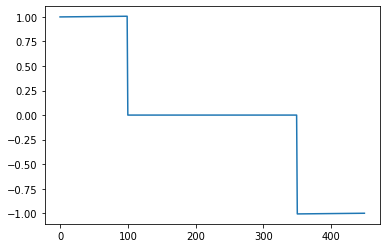

In [40]:
k = 100
l = 250
pre_trigger_delay = 1000

trap_filter = generate_trapezoid_filter(tau, k, l)
plt.figure()
plt.plot(trap_filter)
#plt.title("Trapezoidal Filter Function")
plt.show()

A normalized waveform and the filter lined up over the section over which it is convoluted is shown.

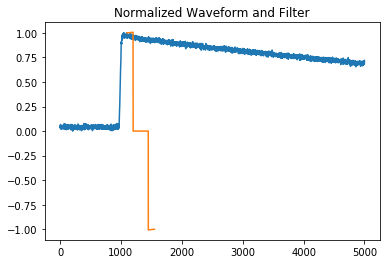

In [41]:
normalized_waveform = raw_pulse_data[0]-np.min(raw_pulse_data[0])
normalized_waveform = normalized_waveform/np.max(normalized_waveform)

convolution_range = np.arange(pre_trigger_delay+k,pre_trigger_delay+k*3+l)

plt.figure()
plt.plot(normalized_waveform)
plt.plot(convolution_range, trap_filter)
plt.title("Normalized Waveform and Filter")
plt.show()

289084664.2162597


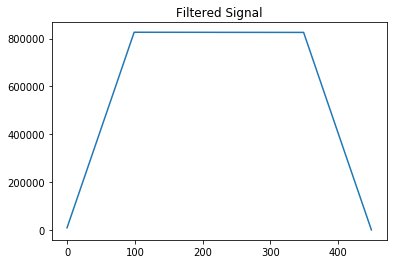

In [42]:
integral, filtered_signal = shape_waveform(raw_pulse_data[0], trap_filter, k, pre_trigger_delay)
print(integral)
plt.figure()
plt.plot(filtered_signal)
plt.title("Filtered Signal")
plt.show()

# Energy Spectrum Calibration
Next, the filter is applied to all pulses in the data.

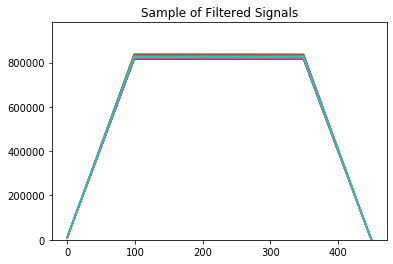

In [43]:

num_pulses = len(raw_pulse_data)
trapezoid_heights = np.zeros(num_pulses)

plt.figure()
for i in range( num_pulses ):
    trapezoid_heights[i], signal = shape_waveform(raw_pulse_data[i], trap_filter, k, pre_trigger_delay)
    if i < 20:
        plt.plot(signal)

plt.title("Sample of Filtered Signals")
plt.ylim((0.8*min(signal), 1.2*max(signal)))
plt.show()

The summed trapezoid values are binned into a histogram, and the known source energies (provided above) are used to automatically perform the calibration. The FWHM of the provided peaks are calculated.

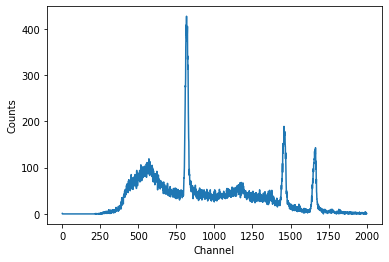

In [44]:
counts = make_histogram(trapezoid_heights, 2000, do_plot = True)

Energy(c) = -0.0c^2 + 0.8794c + -32.3988


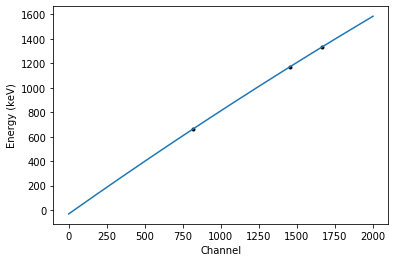

([816, 1456, 1663], [18.07878338509329, 16.3083014552642, 16.01353940891113])

In [46]:
binned_spectrum = Spectrum(counts)

binned_spectrum.calibrate( source_energies, auto_calibrate=True , reset_calibration = True , auto_prominence=300, show_fit = True)

binned_spectrum.calc_FWHMs()

In [26]:
binned_spectrum.show_histogram("Calibrated Spectrum", show_peaks = False)

# Filter Optimization
A wide range of values for k and l are tested to minimize the average FWHM for the peaks.

In [54]:
import numpy as np
from bokeh.io import show, output_file
from bokeh.plotting import figure
import matplotlib.pyplot as plt
from bokeh.models import HoverTool
import scipy.signal as sig
import copy


class Spectrum:
    def __init__(self, counts):
        self.num_channels = len(counts)
        self.counts = counts
        self.channels = np.arange(1, self.num_channels+1)
        self.energies = self.channels
        self.peaks = []
        self.calibrated = False
        self.calibration_coeffs = [1.0]
        self.calibration_channels = []
        self.calibration_energies = []

    def show_histogram(self, title, show_peaks = False):
        if self.calibrated:
            x = np.concatenate((np.array([0.0]),self.energies))
        else:
            x = np.concatenate((np.array([0]),self.channels))
        TOOLTIPS = [
            ("(x,y)", "($x, $y)"),
        ]

        p = figure(title=title, background_fill_color="#fafafa",
                   y_axis_type="log", width=1200, height=700,
                   x_range=(0, np.max(self.energies)),
                   tooltips=TOOLTIPS, tools = "pan,wheel_zoom,box_zoom,reset")
        p.add_tools(HoverTool(mode='vline'))
        p.quad(top=self.counts, bottom=1, left=x[:-1], right=x[1:],
                   fill_color="#036564", line_color="#033649")
        if self.calibrated:
            p.xaxis.axis_label = 'Energy (keV)'
        else:
            p.xaxis.axis_label = 'Channel'
        p.yaxis.axis_label = 'Counts'
        output_file("{0}.html".format(title))
        if len(self.peaks) > 0 and show_peaks:
            for peak in self.peaks:
                p.quad(top=self.counts[peak.centroid], bottom=self.counts[peak.left], left=x[peak.left], right=x[peak.right],
                       fill_color="#00FF00")
        show(p)

    def __add__(self, other):
        new = copy.deepcopy(self)
        new.counts += other.counts
        return new

    def __sub__(self, other):
        new = copy.deepcopy(self)
        new.counts -= other.counts
        return new

    def find_peaks(self, auto_prominence, peak_min_distance=40):
        self.peaks = []
        peaks, props = sig.find_peaks(self.counts, prominence = auto_prominence, distance = peak_min_distance)
        widths, width_heights, left_ips, right_ips = sig.peak_widths(self.counts, peaks, rel_height=0.5)
        for i in range(len(peaks)):
            centroid = peaks[i]
            left_th = int(left_ips[i])
            right_th = int(right_ips[i])
            width = widths[i]
            self.peaks += [Peak(centroid, int(self.counts[centroid]), left_th, right_th)]
        return self.peaks

    def calibrate(self, gamma_energies, known_channels = [], auto_calibrate = False, reset_calibration = False,
                  auto_prominence = 100, show_fit = False):
        if not reset_calibration:
            self.calibration_energies = []
            self.calibration_channels = []
        if auto_calibrate:
            self.find_peaks(auto_prominence)
            while len(self.peaks) < len(gamma_energies):
                auto_prominence -= 10
                self.find_peaks(auto_prominence)
            print(self.peaks)
            for i in range(len( gamma_energies ) ):
                self.calibration_channels += [self.peaks[i].centroid]
                self.calibration_energies += [gamma_energies[i]]
        elif len(known_channels) > 0:
            for i in range(len( gamma_energies ) ):
                self.calibration_channels += [known_channels[i]]
                self.calibration_energies += [gamma_energies[i]]
        else:
            print("Opening plot for manual calibration...")
            self.show_histogram("Calibration")
            for i in range(len(gamma_energies)):
                current_energy = gamma_energies[i]
                self.calibration_energies += [current_energy]
                prompt = "What channel do you think the {0} keV gamma is in? ".format(current_energy)
                self.calibration_channels += [int(input(prompt))]
        coefficients = np.polyfit(self.calibration_channels, self.calibration_energies, 2)
        self.energies = np.polyval(coefficients, self.channels)
        calibration_func = "Energy(c) = {0}c^2 + {1}c + {2}".format( *np.round(coefficients,4) )
        print(calibration_func)
        if show_fit:
            plt.figure()
            plt.plot(self.calibration_channels, self.calibration_energies, 'k.')
            plt.plot(self.channels, self.energies)
            plt.xlabel("Channel")
            plt.ylabel("Energy (keV)")
            plt.show()
        self.calibrated = True
        self.calibration_coeffs = coefficients
        return coefficients

    def calc_FWHMs(self):
        peak_energies = []
        peak_fwhm_vals = []
        for peak in self.peaks:
            peak_energy, peak_fwhm = peak.get_FWHM(self.calibration_coeffs)
            peak_energies += [peak_energy]
            peak_fwhm_vals += [peak_fwhm]
        return (peak_energies, peak_fwhm_vals)


class Peak:
    def __init__(self, centroid, value, left, right):
        self.centroid = centroid
        self.value = value
        self.left = left
        self.right = right

    def __repr__(self):
        return "{0} count peak at {1} between {2} and {3}".format(
            self.value, self.centroid, self.left, self.right)

    def get_FWHM(self, coefficients):
        left_energy = np.polyval(coefficients, self.left)
        right_energy = np.polyval(coefficients, self.right)
        self.FWHM = right_energy-left_energy
        return (self.centroid, self.FWHM)



class Source:
    def __init__(self, activity, energies, intensities):
        self.activity = activity
        self.energies = energies
        self.intensities = intensities

k = 100, l = 200


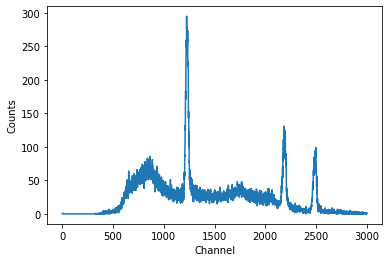

[295 count peak at 1224 between 1211 and 1241, 131 count peak at 2185 between 2171 and 2204, 99 count peak at 2497 between 2471 and 2504]
Energy(c) = -0.0c^2 + 0.5907c + -35.673
16.719744425487836



k = 100, l = 250


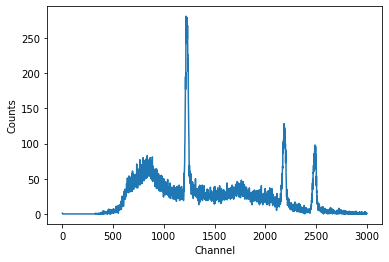

[281 count peak at 1219 between 1209 and 1242, 128 count peak at 2184 between 2171 and 2202, 98 count peak at 2489 between 2469 and 2501]
Energy(c) = -0.0c^2 + 0.5513c + -1.0372
16.861355912119695



k = 100, l = 300


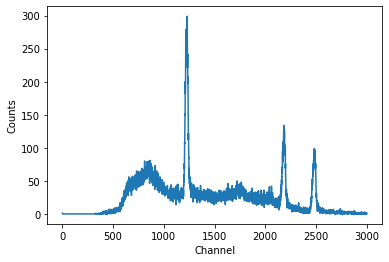

[299 count peak at 1230 between 1209 and 1239, 134 count peak at 2181 between 2166 and 2196, 99 count peak at 2482 between 2465 and 2497]
Energy(c) = -0.0c^2 + 0.5618c + -18.6848
16.380098352418486



k = 100, l = 350


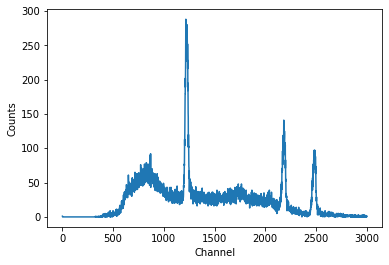

[288 count peak at 1216 between 1207 and 1240, 141 count peak at 2181 between 2167 and 2196, 97 count peak at 2487 between 2466 and 2498]
Energy(c) = -0.0c^2 + 0.5558c + -2.9312
16.49122497124601



k = 100, l = 400


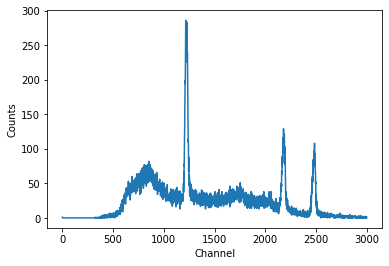

[286 count peak at 1216 between 1206 and 1238, 129 count peak at 2178 between 2162 and 2195, 108 count peak at 2484 between 2466 and 2494]
Energy(c) = -0.0c^2 + 0.5619c + -8.4139
16.349837468640278



k = 100, l = 450


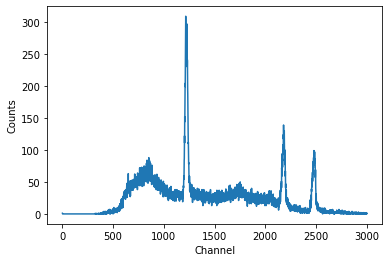

[309 count peak at 1215 between 1206 and 1236, 139 count peak at 2179 between 2164 and 2195, 99 count peak at 2478 between 2462 and 2494]
Energy(c) = 0.0c^2 + 0.5252c + 21.2281
16.47698704131085



k = 100, l = 500


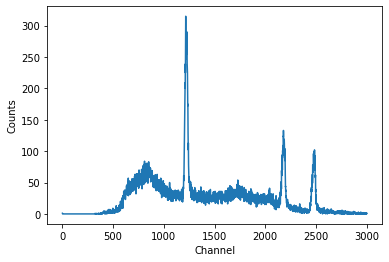

[315 count peak at 1215 between 1206 and 1236, 133 count peak at 2178 between 2167 and 2194, 102 count peak at 2484 between 2464 and 2494]
Energy(c) = -0.0c^2 + 0.5598c + -6.0219
15.278910032872014



k = 100, l = 550


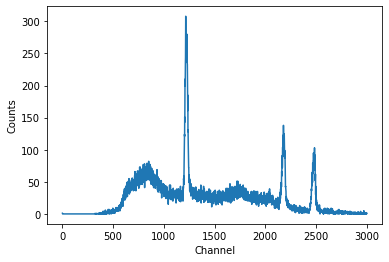

[308 count peak at 1215 between 1206 and 1236, 138 count peak at 2178 between 2167 and 2194, 103 count peak at 2484 between 2464 and 2491]
Energy(c) = -0.0c^2 + 0.5598c + -6.0219
14.761165762036853



k = 100, l = 600


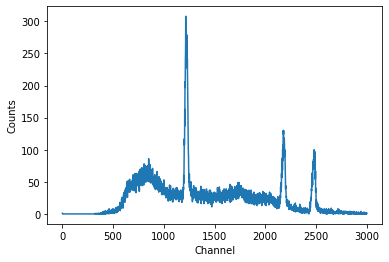

[308 count peak at 1215 between 1206 and 1237, 130 count peak at 2177 between 2168 and 2196, 100 count peak at 2480 between 2465 and 2494]
Energy(c) = -0.0c^2 + 0.5481c + 2.8673
15.527908975512977



k = 100, l = 650


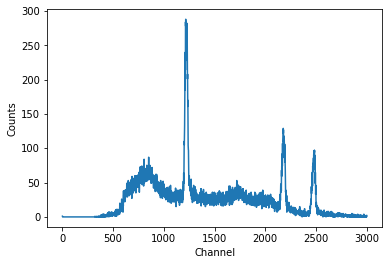

[288 count peak at 1215 between 1204 and 1236, 129 count peak at 2176 between 2162 and 2196, 97 count peak at 2482 between 2464 and 2493]
Energy(c) = -0.0c^2 + 0.5639c + -9.6866
16.706973388397614



k = 100, l = 700


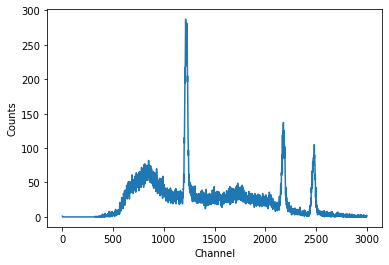

[287 count peak at 1214 between 1204 and 1236, 137 count peak at 2177 between 2167 and 2194, 105 count peak at 2482 between 2463 and 2492]
Energy(c) = -0.0c^2 + 0.5553c + -1.923
15.484007170022588



k = 100, l = 750


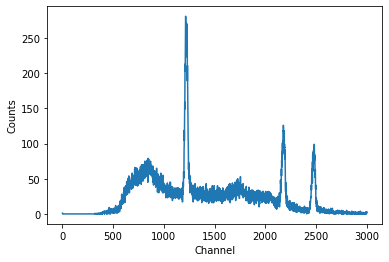

[281 count peak at 1214 between 1203 and 1237, 126 count peak at 2177 between 2159 and 2195, 99 count peak at 2481 between 2463 and 2492]
Energy(c) = -0.0c^2 + 0.5507c + 1.6452
17.43756925856807



k = 100, l = 800


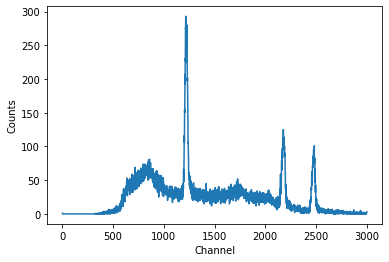

[293 count peak at 1215 between 1203 and 1236, 125 count peak at 2177 between 2161 and 2194, 101 count peak at 2481 between 2459 and 2489]
Energy(c) = -0.0c^2 + 0.5527c + -0.735
16.918454790996027



k = 100, l = 850


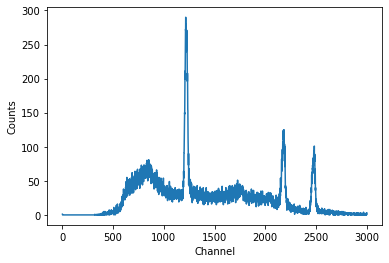

[290 count peak at 1215 between 1203 and 1236, 125 count peak at 2183 between 2161 and 2194, 101 count peak at 2482 between 2459 and 2489]
Energy(c) = 0.0c^2 + 0.5171c + 28.4768
16.961538623540985



k = 100, l = 900


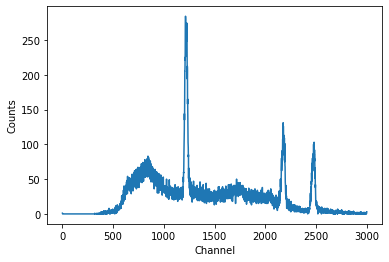

[284 count peak at 1213 between 1203 and 1235, 131 count peak at 2175 between 2160 and 2194, 103 count peak at 2480 between 2461 and 2488]
Energy(c) = -0.0c^2 + 0.5573c + -3.1934
16.37163555317818



k = 100, l = 950


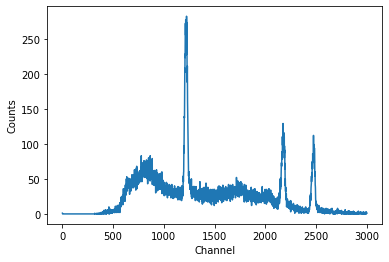

[282 count peak at 1223 between 1203 and 1234, 129 count peak at 2174 between 2160 and 2191, 112 count peak at 2474 between 2460 and 2486]
Energy(c) = -0.0c^2 + 0.5569c + -11.0191
15.703123021509896



k = 100, l = 1000


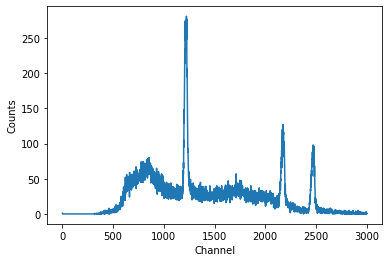

[281 count peak at 1222 between 1200 and 1232, 127 count peak at 2175 between 2163 and 2189, 98 count peak at 2470 between 2452 and 2486]
Energy(c) = 0.0c^2 + 0.5283c + 12.4346
16.499152689031195



k = 100, l = 1050


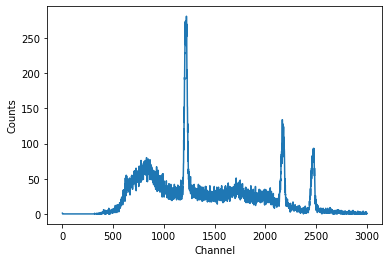

[281 count peak at 1222 between 1200 and 1232, 134 count peak at 2167 between 2157 and 2188, 93 count peak at 2473 between 2452 and 2485]
Energy(c) = -0.0c^2 + 0.5977c + -43.8578
17.04355383724976



k = 100, l = 1100


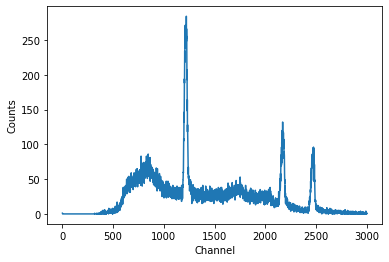

[284 count peak at 1221 between 1200 and 1231, 132 count peak at 2170 between 2158 and 2187, 96 count peak at 2474 between 2454 and 2481]
Energy(c) = -0.0c^2 + 0.5799c + -28.4201
15.472225250978909



k = 100, l = 1150


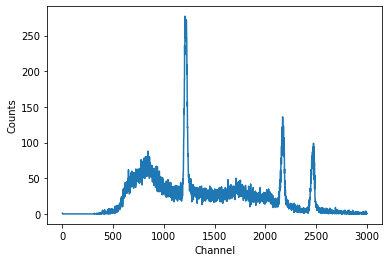

[277 count peak at 1208 between 1197 and 1231, 136 count peak at 2170 between 2158 and 2187, 99 count peak at 2474 between 2450 and 2481]
Energy(c) = -0.0c^2 + 0.5527c + 3.1338
16.570413533398323



k = 100, l = 1200


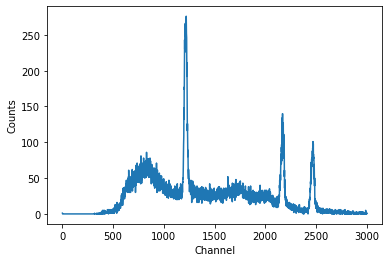

[276 count peak at 1220 between 1199 and 1230, 140 count peak at 2169 between 2162 and 2186, 101 count peak at 2469 between 2452 and 2479]
Energy(c) = -0.0c^2 + 0.5611c + -13.1432
14.657380536195737



k = 150, l = 200


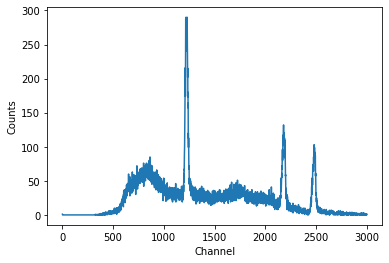

[290 count peak at 1218 between 1206 and 1239, 132 count peak at 2179 between 2164 and 2196, 103 count peak at 2480 between 2464 and 2496]
Energy(c) = -0.0c^2 + 0.5408c + 6.7057
17.169231677992645



k = 150, l = 250


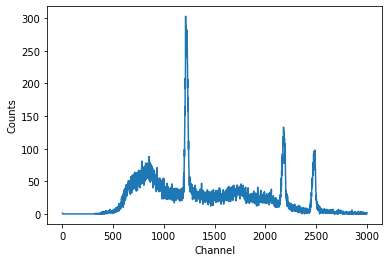

[303 count peak at 1214 between 1208 and 1238, 133 count peak at 2179 between 2166 and 2196, 98 count peak at 2487 between 2463 and 2496]
Energy(c) = -0.0c^2 + 0.5647c + -8.8113
16.25448359185801



k = 150, l = 300


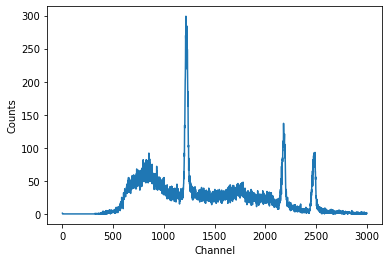

[299 count peak at 1217 between 1206 and 1237, 137 count peak at 2179 between 2164 and 2196, 93 count peak at 2489 between 2465 and 2495]
Energy(c) = -0.0c^2 + 0.5797c + -22.9025
16.25653887425983



k = 150, l = 350


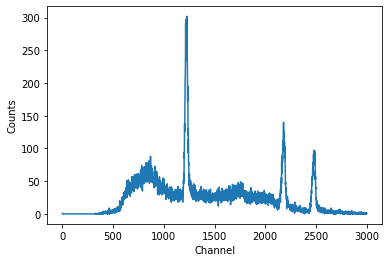

[302 count peak at 1228 between 1206 and 1237, 140 count peak at 2179 between 2163 and 2195, 97 count peak at 2484 between 2461 and 2494]
Energy(c) = -0.0c^2 + 0.5805c + -32.2851
16.997065501092152



k = 150, l = 400


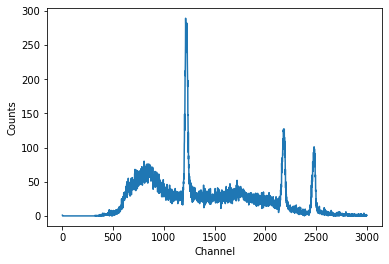

[289 count peak at 1214 between 1206 and 1237, 127 count peak at 2186 between 2163 and 2195, 101 count peak at 2480 between 2463 and 2494]
Energy(c) = 0.0c^2 + 0.4848c + 55.2046
16.689967535746177



k = 150, l = 450


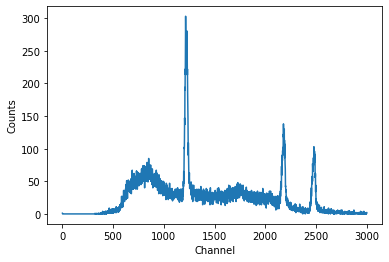

[303 count peak at 1214 between 1206 and 1236, 138 count peak at 2178 between 2163 and 2195, 103 count peak at 2478 between 2464 and 2493]
Energy(c) = 0.0c^2 + 0.53c + 18.0358
16.098940345868982



k = 150, l = 500


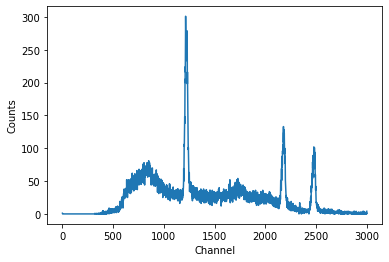

[301 count peak at 1214 between 1206 and 1236, 133 count peak at 2178 between 2160 and 2195, 102 count peak at 2477 between 2460 and 2493]
Energy(c) = 0.0c^2 + 0.5252c + 21.7533
17.364246047300224



k = 150, l = 550


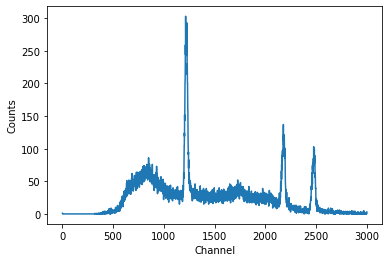

[303 count peak at 1214 between 1205 and 1236, 137 count peak at 2177 between 2164 and 2194, 103 count peak at 2476 between 2463 and 2492]
Energy(c) = 0.0c^2 + 0.5272c + 19.9318
15.952936382946064



k = 150, l = 600


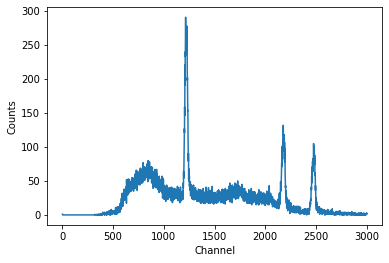

[291 count peak at 1214 between 1203 and 1236, 132 count peak at 2176 between 2159 and 2193, 105 count peak at 2475 between 2459 and 2491]
Energy(c) = 0.0c^2 + 0.5293c + 18.1058
17.559702821575872



k = 150, l = 650


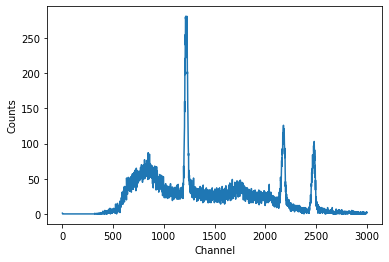

[281 count peak at 1226 between 1203 and 1236, 126 count peak at 2178 between 2159 and 2193, 103 count peak at 2481 between 2458 and 2491]
Energy(c) = -0.0c^2 + 0.569c + -21.9378
17.751062695044578



k = 150, l = 700


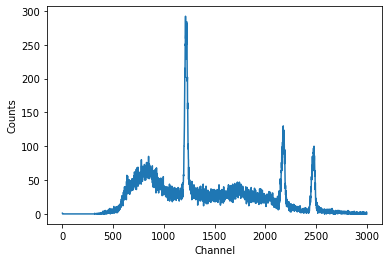

[292 count peak at 1213 between 1202 and 1235, 130 count peak at 2176 between 2162 and 2192, 100 count peak at 2479 between 2455 and 2489]
Energy(c) = -0.0c^2 + 0.5461c + 5.7888
17.101114943924813



k = 150, l = 750


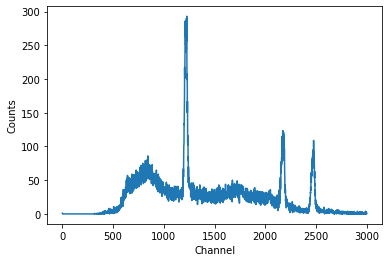

[293 count peak at 1225 between 1201 and 1233, 123 count peak at 2173 between 2154 and 2189, 109 count peak at 2475 between 2453 and 2483]
Energy(c) = -0.0c^2 + 0.5728c + -25.3213
17.2889890253183



k = 150, l = 800


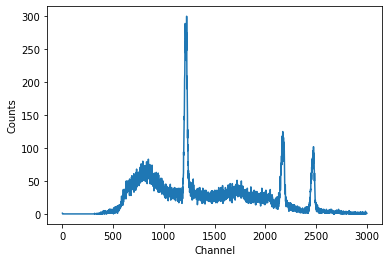

[300 count peak at 1224 between 1201 and 1232, 125 count peak at 2171 between 2153 and 2188, 102 count peak at 2474 between 2451 and 2482]
Energy(c) = -0.0c^2 + 0.5796c + -30.3452
17.267542631350654



k = 150, l = 850


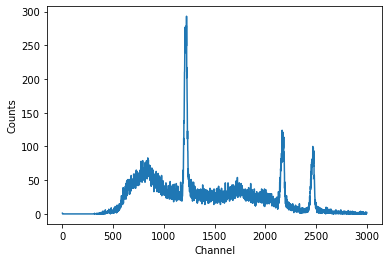

[293 count peak at 1223 between 1199 and 1230, 124 count peak at 2165 between 2153 and 2186, 100 count peak at 2467 between 2449 and 2482]
Energy(c) = -0.0c^2 + 0.5857c + -35.7472
17.337163835757604



k = 150, l = 900


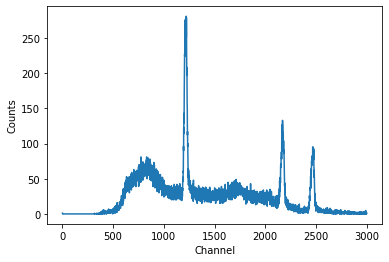

[281 count peak at 1220 between 1199 and 1230, 133 count peak at 2169 between 2153 and 2185, 95 count peak at 2466 between 2448 and 2481]
Energy(c) = -0.0c^2 + 0.5466c + -1.7963
17.21038760996161



k = 150, l = 950


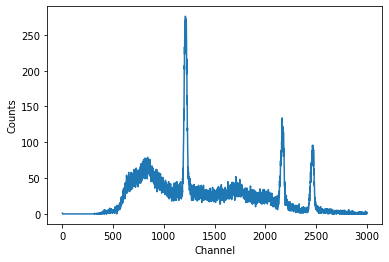

[276 count peak at 1212 between 1197 and 1229, 134 count peak at 2166 between 2152 and 2183, 96 count peak at 2464 between 2450 and 2480]
Energy(c) = -0.0c^2 + 0.5409c + 8.165
16.600658069811896



k = 150, l = 1000


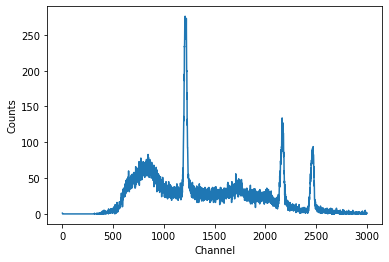

[276 count peak at 1209 between 1197 and 1228, 134 count peak at 2165 between 2151 and 2183, 94 count peak at 2471 between 2445 and 2479]
Energy(c) = -0.0c^2 + 0.5741c + -15.4836
17.092380726874392



k = 150, l = 1050


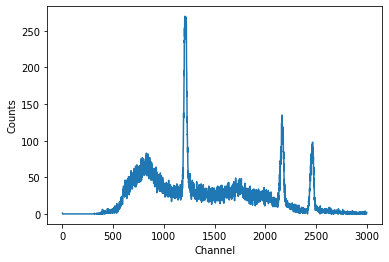

[270 count peak at 1208 between 1195 and 1227, 135 count peak at 2164 between 2152 and 2181, 98 count peak at 2465 between 2444 and 2477]
Energy(c) = -0.0c^2 + 0.551c + 2.9501
16.688839080049622



k = 150, l = 1100


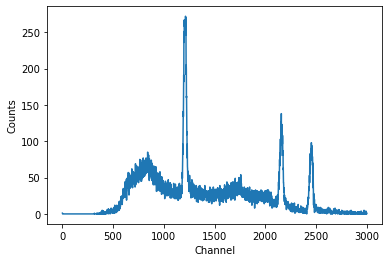

[272 count peak at 1213 between 1192 and 1223, 138 count peak at 2157 between 2145 and 2174, 98 count peak at 2453 between 2436 and 2466]
Energy(c) = -0.0c^2 + 0.5523c + -3.6497
16.211144809845376



k = 150, l = 1150


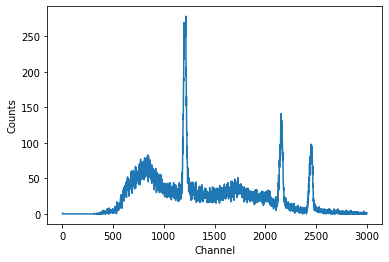

[278 count peak at 1216 between 1191 and 1222, 141 count peak at 2155 between 2141 and 2172, 98 count peak at 2453 between 2433 and 2467]
Energy(c) = -0.0c^2 + 0.5729c + -22.5781
17.289139664594057



k = 150, l = 1200


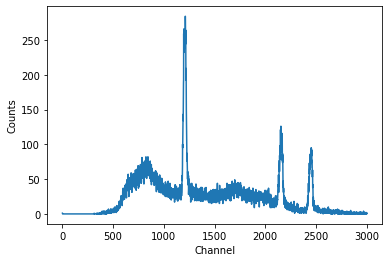

[284 count peak at 1211 between 1190 and 1221, 126 count peak at 2153 between 2139 and 2171, 95 count peak at 2451 between 2432 and 2465]
Energy(c) = -0.0c^2 + 0.5663c + -13.9428
17.25837932282847



k = 200, l = 200


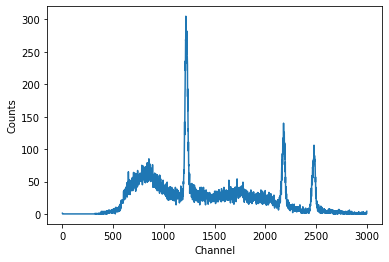

[305 count peak at 1216 between 1205 and 1236, 140 count peak at 2179 between 2166 and 2194, 106 count peak at 2479 between 2462 and 2492]
Energy(c) = -0.0c^2 + 0.532c + 15.15
15.754870152090726



k = 200, l = 250


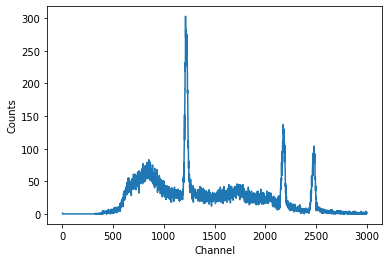

[303 count peak at 1213 between 1205 and 1235, 137 count peak at 2176 between 2161 and 2194, 104 count peak at 2478 between 2462 and 2492]
Energy(c) = -0.0c^2 + 0.5414c + 9.4112
16.415977066101618



k = 200, l = 300


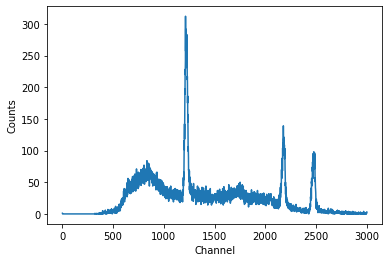

[312 count peak at 1213 between 1205 and 1234, 139 count peak at 2177 between 2168 and 2192, 98 count peak at 2476 between 2462 and 2491]
Energy(c) = 0.0c^2 + 0.5252c + 22.2785
14.525831000959974



k = 200, l = 350


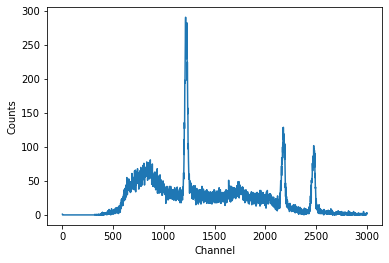

[291 count peak at 1214 between 1204 and 1236, 129 count peak at 2177 between 2160 and 2193, 102 count peak at 2476 between 2458 and 2490]
Energy(c) = 0.0c^2 + 0.5272c + 19.9318
17.19478247326947



k = 200, l = 400


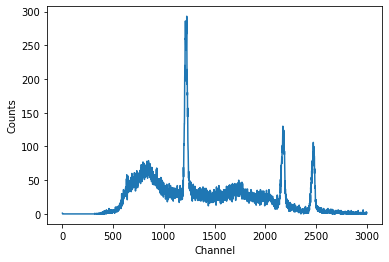

[293 count peak at 1225 between 1203 and 1232, 130 count peak at 2172 between 2155 and 2190, 106 count peak at 2472 between 2457 and 2486]
Energy(c) = -0.0c^2 + 0.5654c + -19.7841
16.620575807777374



k = 200, l = 450


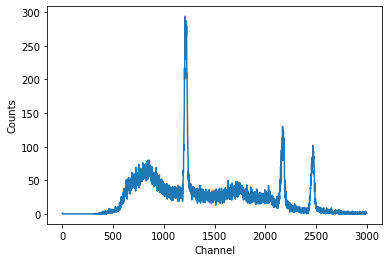

[294 count peak at 1210 between 1200 and 1232, 130 count peak at 2169 between 2155 and 2186, 102 count peak at 2467 between 2450 and 2482]
Energy(c) = 0.0c^2 + 0.5306c + 18.4725
16.904560743561017



k = 200, l = 500


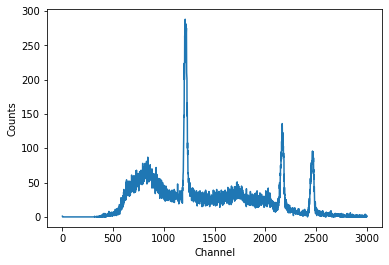

[288 count peak at 1210 between 1197 and 1230, 136 count peak at 2166 between 2151 and 2183, 96 count peak at 2464 between 2445 and 2479]
Energy(c) = -0.0c^2 + 0.5368c + 12.951
17.64866919139293



k = 200, l = 550


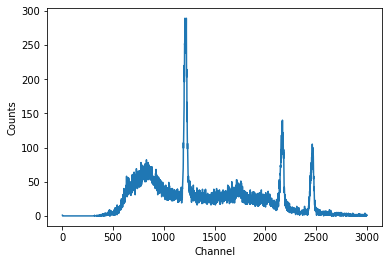

[289 count peak at 1221 between 1196 and 1226, 140 count peak at 2168 between 2152 and 2181, 105 count peak at 2462 between 2447 and 2477]
Energy(c) = 0.0c^2 + 0.5359c + 5.4925
16.0432236233025



k = 200, l = 600


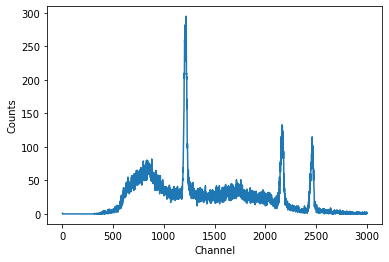

[295 count peak at 1220 between 1195 and 1227, 133 count peak at 2164 between 2149 and 2181, 115 count peak at 2461 between 2446 and 2473]
Energy(c) = -0.0c^2 + 0.5572c + -11.363
16.374905953096874



k = 200, l = 650


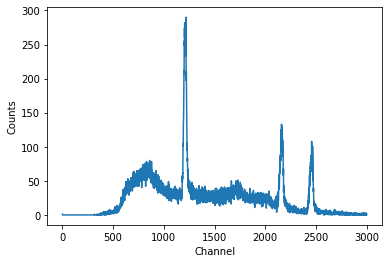

[290 count peak at 1217 between 1194 and 1225, 133 count peak at 2159 between 2144 and 2176, 108 count peak at 2456 between 2441 and 2468]
Energy(c) = -0.0c^2 + 0.5615c + -13.5395
16.21420400786648



k = 200, l = 700


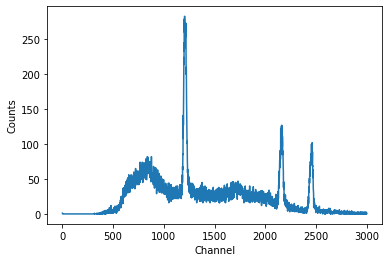

[283 count peak at 1204 between 1192 and 1224, 127 count peak at 2161 between 2142 and 2175, 102 count peak at 2461 between 2437 and 2470]
Energy(c) = -0.0c^2 + 0.5442c + 10.6297
17.41070594941819



k = 200, l = 750


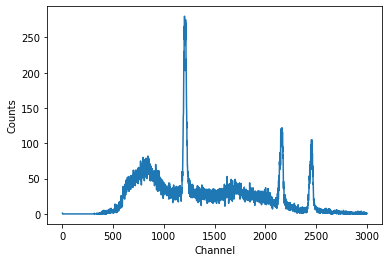

[280 count peak at 1203 between 1192 and 1224, 122 count peak at 2164 between 2142 and 2174, 105 count peak at 2457 between 2438 and 2467]
Energy(c) = 0.0c^2 + 0.502c + 44.7672
16.634398115653237



k = 200, l = 800


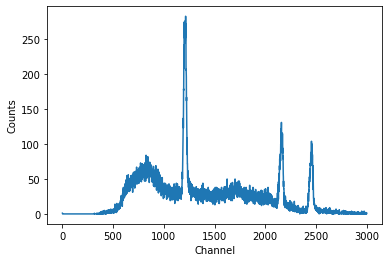

[283 count peak at 1214 between 1192 and 1223, 131 count peak at 2158 between 2142 and 2174, 104 count peak at 2454 between 2439 and 2466]
Energy(c) = -0.0c^2 + 0.5523c + -4.2019
16.213140455080595



k = 200, l = 850


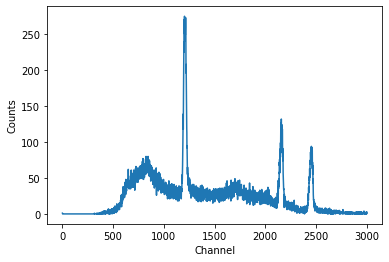

[275 count peak at 1203 between 1191 and 1223, 132 count peak at 2157 between 2141 and 2173, 94 count peak at 2453 between 2434 and 2467]
Energy(c) = 0.0c^2 + 0.5312c + 20.5236
17.362269037822784



k = 200, l = 900


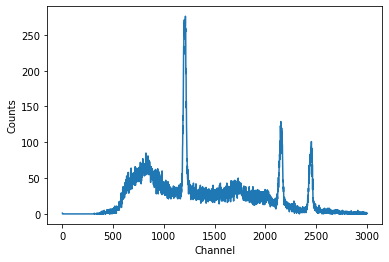

[276 count peak at 1212 between 1189 and 1221, 129 count peak at 2152 between 2138 and 2170, 101 count peak at 2453 between 2431 and 2464]
Energy(c) = -0.0c^2 + 0.585c + -29.5015
17.39200169065532



k = 200, l = 950


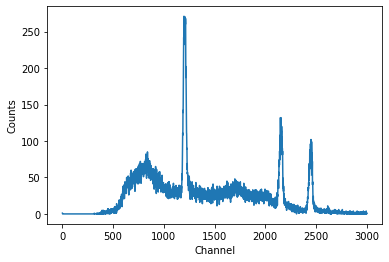

[271 count peak at 1198 between 1187 and 1221, 132 count peak at 2152 between 2138 and 2169, 102 count peak at 2449 between 2430 and 2463]
Energy(c) = 0.0c^2 + 0.5361c + 19.4431
17.516274950156042



k = 200, l = 1000


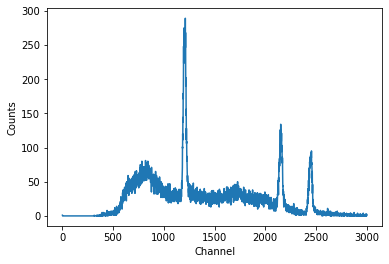

[289 count peak at 1211 between 1189 and 1220, 134 count peak at 2151 between 2136 and 2168, 95 count peak at 2454 between 2429 and 2462]
Energy(c) = -0.0c^2 + 0.5944c + -36.1847
17.15966197538607



k = 200, l = 1050


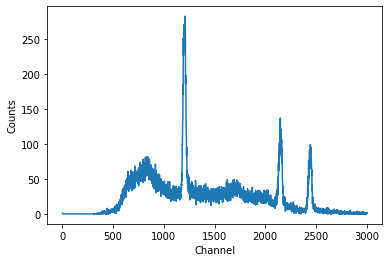

[282 count peak at 1209 between 1187 and 1218, 137 count peak at 2147 between 2133 and 2162, 99 count peak at 2443 between 2425 and 2458]
Energy(c) = -0.0c^2 + 0.5652c + -12.9388
16.810775530431517



k = 200, l = 1100


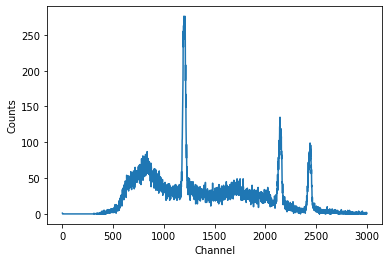

[276 count peak at 1196 between 1184 and 1216, 135 count peak at 2144 between 2130 and 2162, 99 count peak at 2440 between 2422 and 2455]
Energy(c) = -0.0c^2 + 0.5437c + 13.1958
17.425645226467015



k = 200, l = 1150


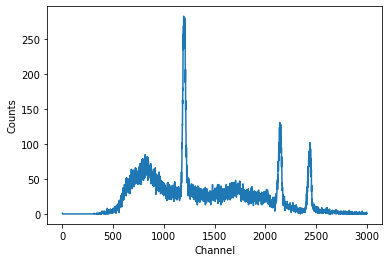

[283 count peak at 1195 between 1183 and 1215, 131 count peak at 2142 between 2128 and 2158, 102 count peak at 2438 between 2420 and 2453]
Energy(c) = -0.0c^2 + 0.5458c + 11.8842
17.077263130717864



k = 200, l = 1200


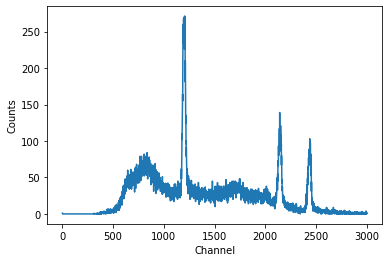

[271 count peak at 1207 between 1182 and 1214, 139 count peak at 2141 between 2128 and 2157, 103 count peak at 2437 between 2418 and 2452]
Energy(c) = -0.0c^2 + 0.5739c + -19.5554
17.21669068309988



k = 250, l = 200


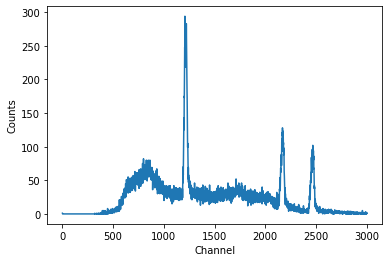

[294 count peak at 1207 between 1199 and 1230, 128 count peak at 2168 between 2152 and 2184, 102 count peak at 2467 between 2452 and 2481]
Energy(c) = 0.0c^2 + 0.5313c + 19.9943
16.32801557286704



k = 250, l = 250


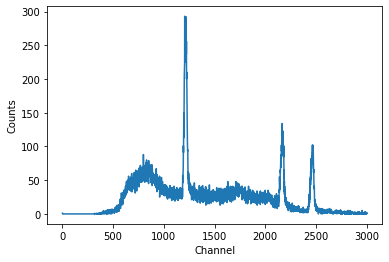

[293 count peak at 1205 between 1198 and 1229, 134 count peak at 2165 between 2155 and 2182, 102 count peak at 2468 between 2449 and 2478]
Energy(c) = -0.0c^2 + 0.5521c + 4.7166
15.372344649136267



k = 250, l = 300


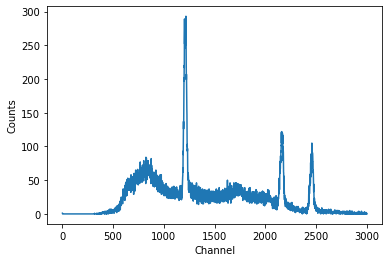

[293 count peak at 1217 between 1195 and 1227, 122 count peak at 2160 between 2143 and 2178, 105 count peak at 2458 between 2443 and 2473]
Energy(c) = -0.0c^2 + 0.5642c + -15.4141
17.43453721928533



k = 250, l = 350


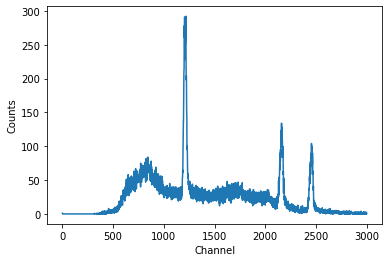

[292 count peak at 1216 between 1193 and 1225, 134 count peak at 2159 between 2144 and 2174, 104 count peak at 2454 between 2440 and 2469]
Energy(c) = -0.0c^2 + 0.5495c + -3.3652
16.42507808908897



k = 250, l = 400


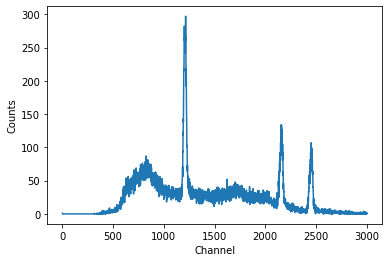

[297 count peak at 1214 between 1192 and 1223, 134 count peak at 2156 between 2141 and 2172, 107 count peak at 2452 between 2437 and 2467]
Energy(c) = -0.0c^2 + 0.5566c + -8.0365
16.591639569680826



k = 250, l = 450


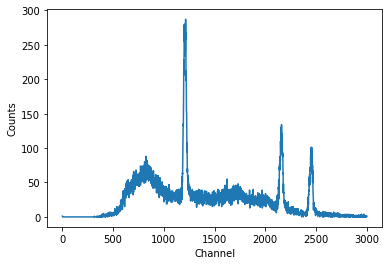

[287 count peak at 1214 between 1192 and 1224, 134 count peak at 2159 between 2142 and 2173, 101 count peak at 2452 between 2437 and 2464]
Energy(c) = 0.0c^2 + 0.5351c + 9.355
16.26326280017501



k = 250, l = 500


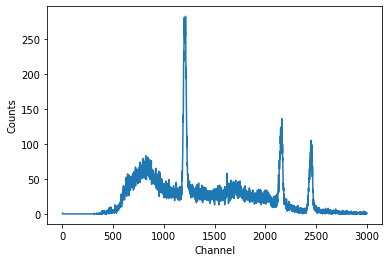

[282 count peak at 1213 between 1191 and 1223, 136 count peak at 2161 between 2140 and 2171, 105 count peak at 2450 between 2436 and 2465]
Energy(c) = 0.0c^2 + 0.5082c + 31.5509
16.67936327592588



k = 250, l = 550


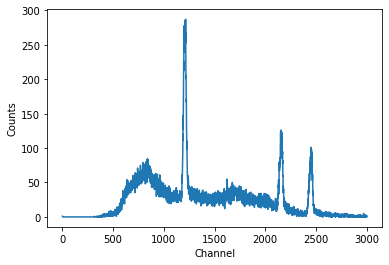

[287 count peak at 1214 between 1190 and 1222, 126 count peak at 2155 between 2139 and 2171, 101 count peak at 2451 between 2432 and 2465]
Energy(c) = -0.0c^2 + 0.5587c + -9.9611
17.50181647379577



k = 250, l = 600


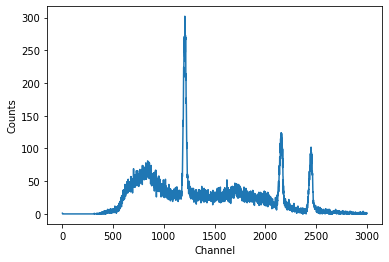

[302 count peak at 1206 between 1191 and 1221, 124 count peak at 2155 between 2139 and 2171, 102 count peak at 2450 between 2432 and 2465]
Energy(c) = 0.0c^2 + 0.5367c + 13.4412
17.08101922552521



k = 250, l = 650


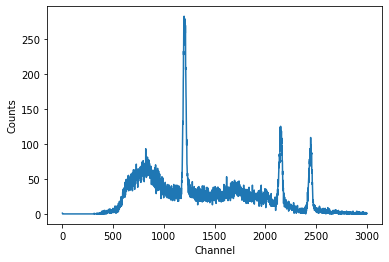

[282 count peak at 1199 between 1188 and 1220, 125 count peak at 2150 between 2132 and 2168, 109 count peak at 2446 between 2431 and 2461]
Energy(c) = 0.0c^2 + 0.5374c + 17.1275
17.57317537135964



k = 250, l = 700


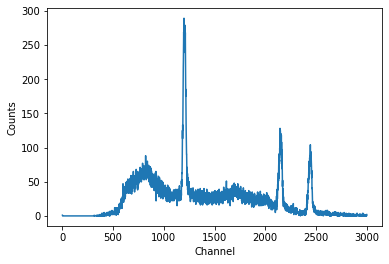

[289 count peak at 1198 between 1186 and 1218, 128 count peak at 2144 between 2133 and 2165, 104 count peak at 2443 between 2425 and 2458]
Energy(c) = -0.0c^2 + 0.5624c + -2.7438
17.372371308523764



k = 250, l = 750


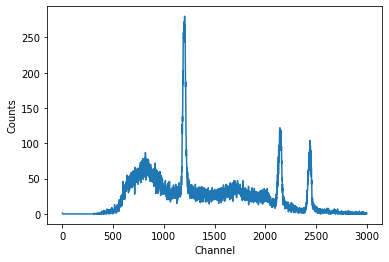

[280 count peak at 1204 between 1184 and 1216, 122 count peak at 2143 between 2129 and 2162, 104 count peak at 2439 between 2420 and 2454]
Energy(c) = -0.0c^2 + 0.5629c + -8.1954
17.881542260056978



k = 250, l = 800


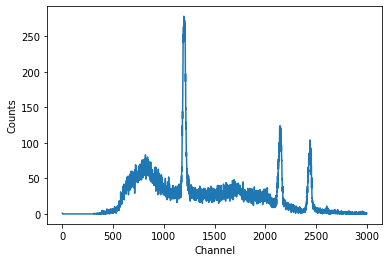

[278 count peak at 1196 between 1184 and 1216, 124 count peak at 2144 between 2129 and 2162, 104 count peak at 2439 between 2421 and 2454]
Energy(c) = 0.0c^2 + 0.5388c + 16.9558
17.63055343505937



k = 250, l = 850


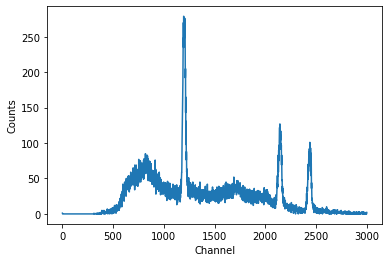

[279 count peak at 1195 between 1183 and 1215, 127 count peak at 2143 between 2128 and 2161, 101 count peak at 2438 between 2422 and 2453]
Energy(c) = 0.0c^2 + 0.5388c + 17.4946
17.27059399013179



k = 250, l = 900


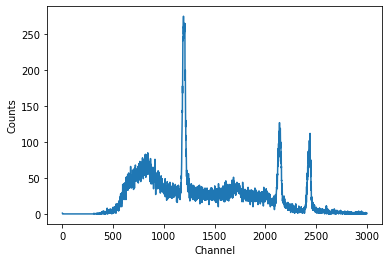

[275 count peak at 1193 between 1180 and 1213, 127 count peak at 2139 between 2125 and 2156, 112 count peak at 2440 between 2418 and 2445]
Energy(c) = -0.0c^2 + 0.5718c + -7.1481
16.278629008422325



k = 250, l = 950


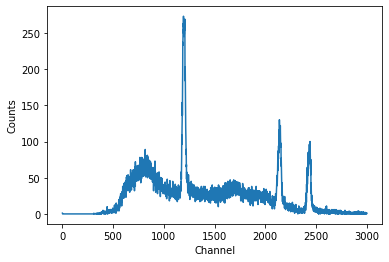

[273 count peak at 1193 between 1182 and 1212, 130 count peak at 2138 between 2124 and 2154, 100 count peak at 2440 between 2415 and 2448]
Energy(c) = -0.0c^2 + 0.5785c + -12.5736
16.5908448960782



k = 250, l = 1000


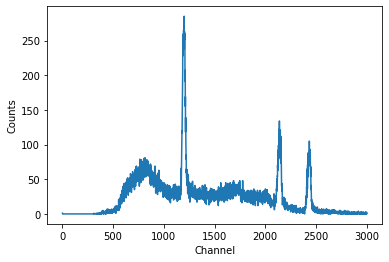

[285 count peak at 1200 between 1180 and 1212, 134 count peak at 2138 between 2124 and 2156, 105 count peak at 2433 between 2415 and 2448]
Energy(c) = -0.0c^2 + 0.5601c + -4.0701
17.558519478846506



k = 250, l = 1050


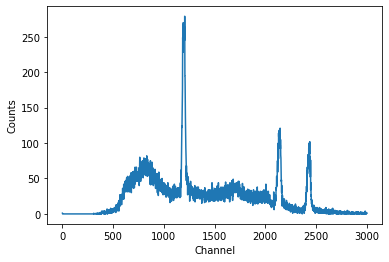

[279 count peak at 1205 between 1179 and 1211, 121 count peak at 2145 between 2121 and 2155, 102 count peak at 2437 between 2412 and 2445]
Energy(c) = 0.0c^2 + 0.5408c + 8.5786
17.974919908025942



k = 250, l = 1100


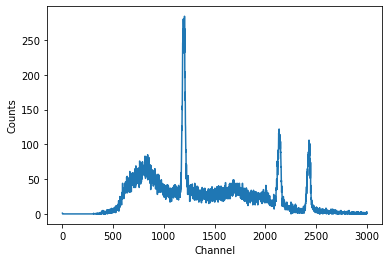

[284 count peak at 1203 between 1178 and 1210, 122 count peak at 2135 between 2121 and 2155, 106 count peak at 2430 between 2411 and 2442]
Energy(c) = -0.0c^2 + 0.5733c + -17.3465
17.628037261974896



k = 250, l = 1150


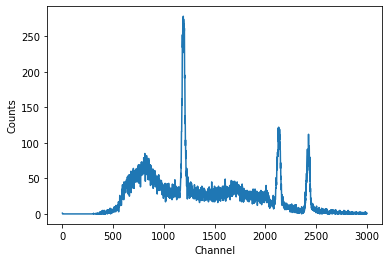

[278 count peak at 1191 between 1175 and 1208, 122 count peak at 2131 between 2117 and 2148, 112 count peak at 2425 between 2407 and 2437]
Energy(c) = -0.0c^2 + 0.5508c + 8.5144
17.02170491593309



k = 250, l = 1200


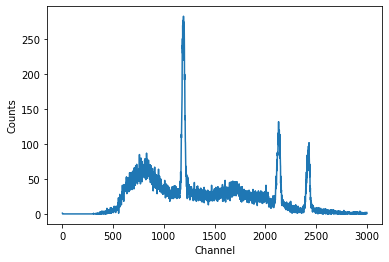

[283 count peak at 1193 between 1175 and 1207, 132 count peak at 2130 between 2116 and 2148, 102 count peak at 2430 between 2405 and 2438]
Energy(c) = -0.0c^2 + 0.5863c + -20.4816
17.448143363797385



k = 300, l = 200


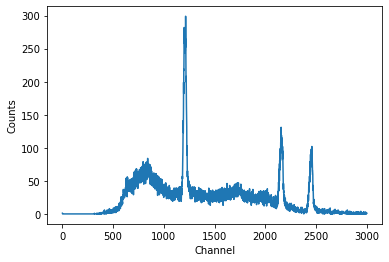

[299 count peak at 1214 between 1192 and 1223, 131 count peak at 2155 between 2140 and 2172, 102 count peak at 2458 between 2438 and 2467]
Energy(c) = -0.0c^2 + 0.5923c + -36.0364
16.452949366321338



k = 300, l = 250


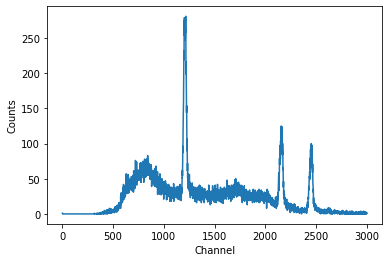

[281 count peak at 1214 between 1191 and 1224, 125 count peak at 2156 between 2138 and 2172, 100 count peak at 2452 between 2437 and 2467]
Energy(c) = -0.0c^2 + 0.5566c + -8.0365
17.495585354882376



k = 300, l = 300


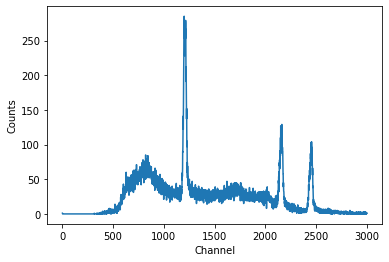

[285 count peak at 1200 between 1191 and 1222, 129 count peak at 2162 between 2141 and 2172, 104 count peak at 2455 between 2437 and 2466]
Energy(c) = 0.0c^2 + 0.5c + 48.0734
16.269864412683926



k = 300, l = 350


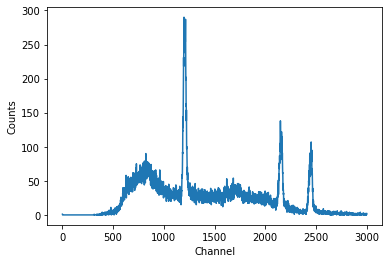

[290 count peak at 1198 between 1189 and 1220, 138 count peak at 2148 between 2137 and 2168, 107 count peak at 2451 between 2433 and 2462]
Energy(c) = -0.0c^2 + 0.5727c + -9.7062
16.177389051920727



k = 300, l = 400


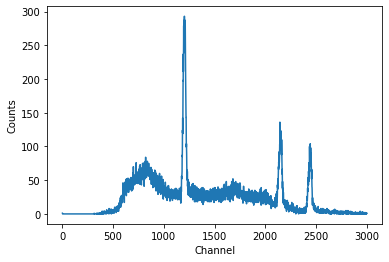

[293 count peak at 1202 between 1186 and 1217, 136 count peak at 2143 between 2133 and 2164, 104 count peak at 2442 between 2427 and 2455]
Energy(c) = -0.0c^2 + 0.5731c + -14.4439
16.180481052076555



k = 300, l = 450


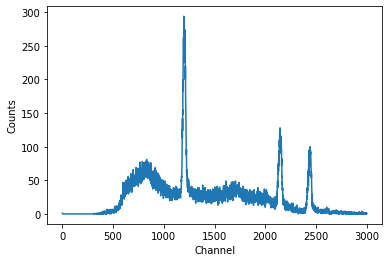

[294 count peak at 1196 between 1184 and 1216, 128 count peak at 2144 between 2129 and 2162, 100 count peak at 2442 between 2424 and 2454]
Energy(c) = -0.0c^2 + 0.5534c + 5.7693
17.02162347672538



k = 300, l = 500


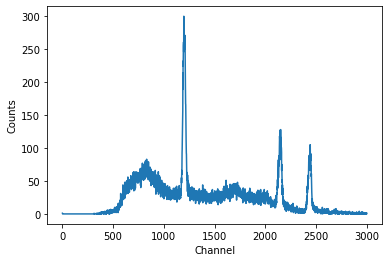

[300 count peak at 1196 between 1185 and 1215, 128 count peak at 2150 between 2129 and 2159, 105 count peak at 2442 between 2424 and 2453]
Energy(c) = 0.0c^2 + 0.5114c + 39.4652
16.016411607025095



k = 300, l = 550


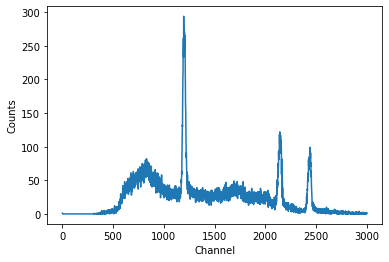

[294 count peak at 1195 between 1184 and 1215, 122 count peak at 2142 between 2124 and 2158, 99 count peak at 2437 between 2418 and 2452]
Energy(c) = -0.0c^2 + 0.5409c + 15.6396
17.821036067765817



k = 300, l = 600


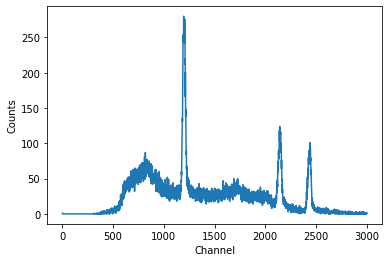

[280 count peak at 1195 between 1183 and 1213, 124 count peak at 2141 between 2127 and 2157, 101 count peak at 2439 between 2417 and 2451]
Energy(c) = -0.0c^2 + 0.5576c + 2.6061
16.85467269078269



k = 300, l = 650


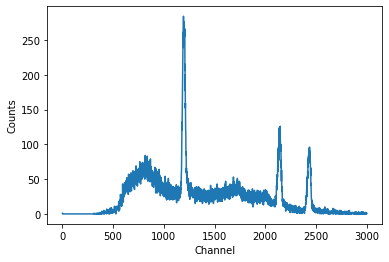

[284 count peak at 1193 between 1180 and 1212, 126 count peak at 2146 between 2124 and 2154, 96 count peak at 2435 between 2411 and 2447]
Energy(c) = 0.0c^2 + 0.4982c + 50.8917
17.736131878061354



k = 300, l = 700


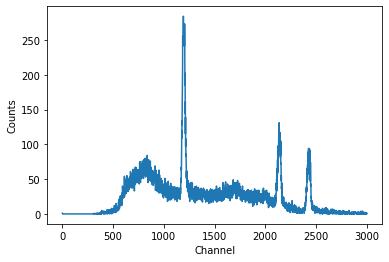

[284 count peak at 1192 between 1179 and 1211, 131 count peak at 2136 between 2122 and 2154, 94 count peak at 2433 between 2412 and 2442]
Energy(c) = -0.0c^2 + 0.557c + 4.2357
16.908964552447628



k = 300, l = 750


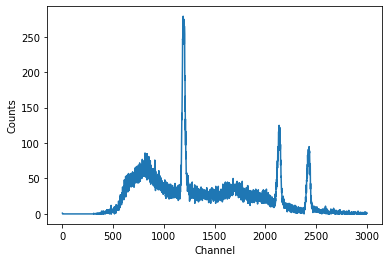

[279 count peak at 1190 between 1178 and 1210, 125 count peak at 2135 between 2120 and 2152, 95 count peak at 2431 between 2407 and 2443]
Energy(c) = -0.0c^2 + 0.55c + 10.9094
17.9951792695194



k = 300, l = 800


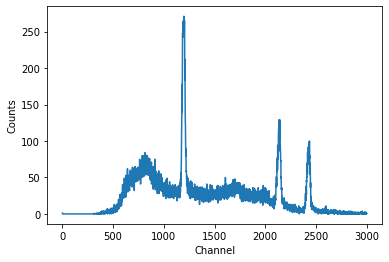

[271 count peak at 1197 between 1177 and 1210, 129 count peak at 2142 between 2120 and 2152, 100 count peak at 2434 between 2409 and 2442]
Energy(c) = 0.0c^2 + 0.5302c + 22.315
17.73618018874629



k = 300, l = 850


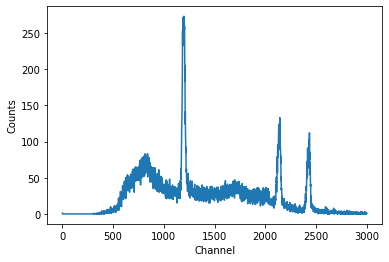

[273 count peak at 1197 between 1177 and 1209, 133 count peak at 2142 between 2119 and 2150, 112 count peak at 2434 between 2414 and 2440]
Energy(c) = 0.0c^2 + 0.5302c + 22.315
16.100485365223904



k = 300, l = 900


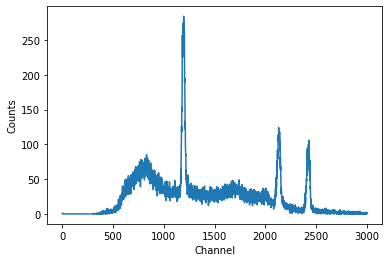

[284 count peak at 1195 between 1175 and 1208, 124 count peak at 2131 between 2116 and 2148, 106 count peak at 2431 between 2406 and 2437]
Energy(c) = -0.0c^2 + 0.5885c + -23.5635
17.294628355046672



k = 300, l = 950


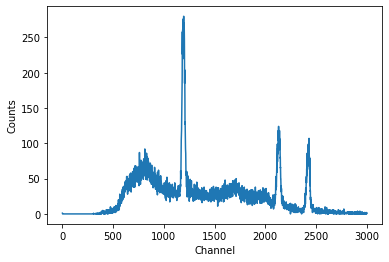

[280 count peak at 1195 between 1175 and 1207, 124 count peak at 2130 between 2115 and 2147, 107 count peak at 2430 between 2405 and 2436]
Energy(c) = -0.0c^2 + 0.5907c + -25.4776
17.119717860443036



k = 300, l = 1000


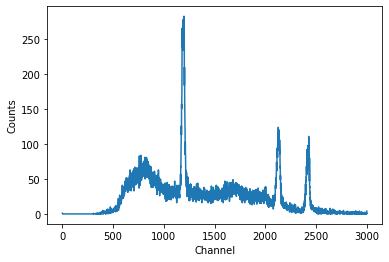

[283 count peak at 1198 between 1173 and 1205, 124 count peak at 2127 between 2113 and 2146, 111 count peak at 2427 between 2407 and 2433]
Energy(c) = -0.0c^2 + 0.604c + -38.8778
16.488517131923988



k = 300, l = 1050


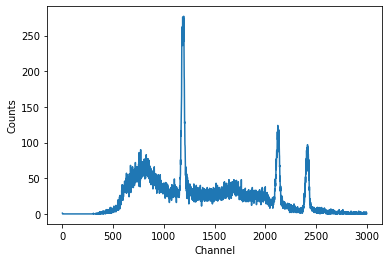

[277 count peak at 1195 between 1170 and 1203, 124 count peak at 2122 between 2107 and 2140, 97 count peak at 2415 between 2396 and 2427]
Energy(c) = -0.0c^2 + 0.5742c + -14.8546
17.737705643048987



k = 300, l = 1100


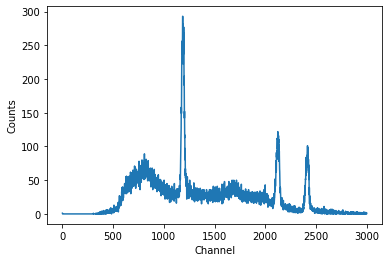

[293 count peak at 1185 between 1170 and 1201, 122 count peak at 2122 between 2108 and 2140, 101 count peak at 2415 between 2396 and 2428]
Energy(c) = -0.0c^2 + 0.5523c + 9.9632
17.255779492134632



k = 300, l = 1150


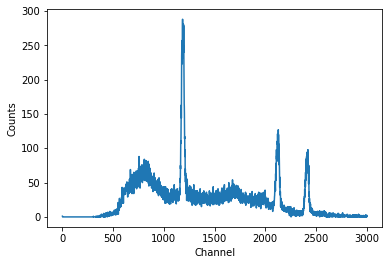

[288 count peak at 1184 between 1172 and 1202, 127 count peak at 2127 between 2106 and 2137, 98 count peak at 2419 between 2394 and 2425]
Energy(c) = 0.0c^2 + 0.5345c + 25.513
16.67324960141396



k = 300, l = 1200


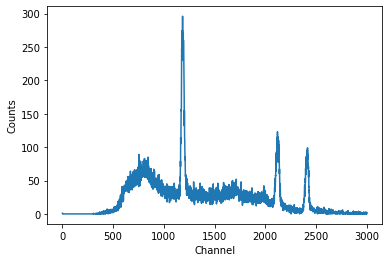

[296 count peak at 1184 between 1169 and 1200, 123 count peak at 2119 between 2105 and 2137, 99 count peak at 2415 between 2394 and 2427]
Energy(c) = -0.0c^2 + 0.5713c + -4.4667
17.38161208969973



k = 350, l = 200


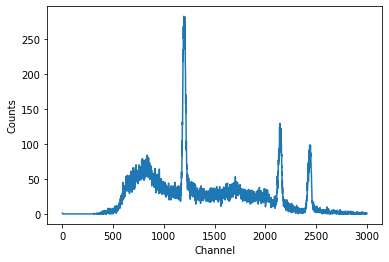

[282 count peak at 1197 between 1184 and 1217, 129 count peak at 2144 between 2126 and 2160, 98 count peak at 2439 between 2424 and 2454]
Energy(c) = -0.0c^2 + 0.5409c + 14.5578
17.46152601023266



k = 350, l = 250


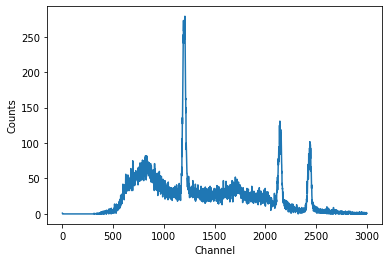

[279 count peak at 1207 between 1183 and 1217, 131 count peak at 2143 between 2125 and 2161, 102 count peak at 2438 between 2423 and 2453]
Energy(c) = -0.0c^2 + 0.5645c + -11.854
18.132161762889837



k = 350, l = 300


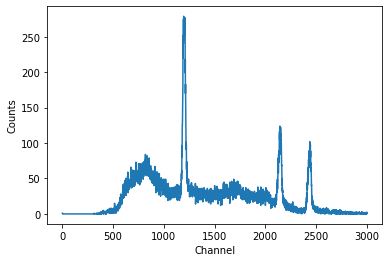

[279 count peak at 1195 between 1183 and 1216, 124 count peak at 2143 between 2128 and 2161, 102 count peak at 2437 between 2419 and 2452]
Energy(c) = 0.0c^2 + 0.5339c + 21.2814
17.835470174396466



k = 350, l = 350


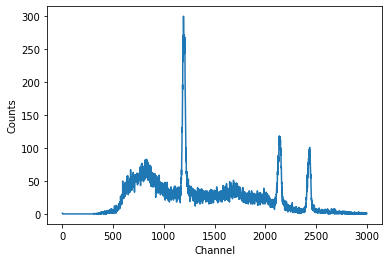

[300 count peak at 1193 between 1181 and 1213, 118 count peak at 2135 between 2124 and 2157, 101 count peak at 2436 between 2414 and 2448]
Energy(c) = -0.0c^2 + 0.5803c + -14.6241
17.719436462405763



k = 350, l = 400


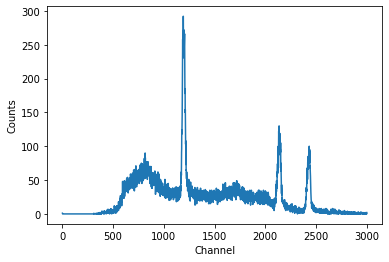

[292 count peak at 1191 between 1180 and 1211, 130 count peak at 2135 between 2121 and 2151, 100 count peak at 2432 between 2412 and 2444]
Energy(c) = -0.0c^2 + 0.557c + 4.7927
16.724929922699175



k = 350, l = 450


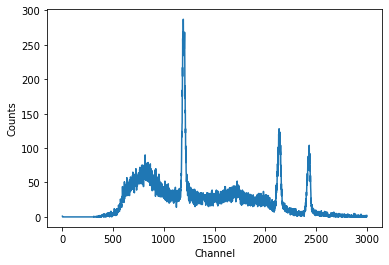

[287 count peak at 1191 between 1180 and 1211, 128 count peak at 2135 between 2121 and 2151, 104 count peak at 2432 between 2415 and 2442]
Energy(c) = -0.0c^2 + 0.557c + 4.7927
15.8333370529067



k = 350, l = 500


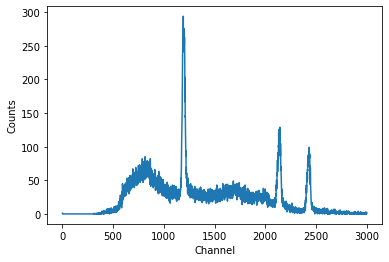

[294 count peak at 1191 between 1179 and 1209, 129 count peak at 2143 between 2121 and 2150, 99 count peak at 2432 between 2411 and 2441]
Energy(c) = 0.0c^2 + 0.5003c + 50.0671
16.104411148770094



k = 350, l = 550


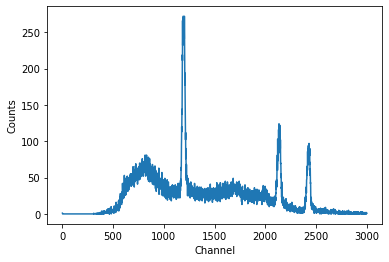

[272 count peak at 1202 between 1176 and 1210, 124 count peak at 2134 between 2120 and 2152, 97 count peak at 2430 between 2408 and 2442]
Energy(c) = -0.0c^2 + 0.5782c + -20.5678
18.151026318709267



k = 350, l = 600


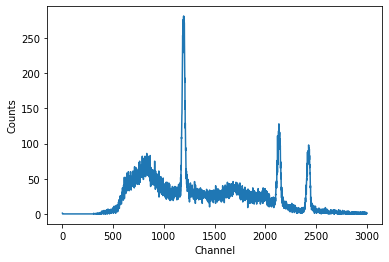

[281 count peak at 1194 between 1177 and 1209, 128 count peak at 2133 between 2119 and 2148, 98 count peak at 2426 between 2408 and 2442]
Energy(c) = -0.0c^2 + 0.548c + 8.7881
17.23485635284025



k = 350, l = 650


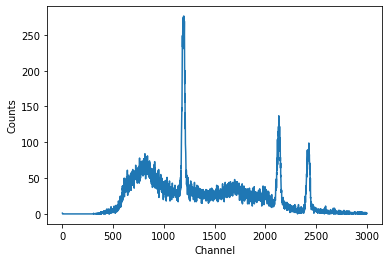

[276 count peak at 1194 between 1175 and 1208, 137 count peak at 2132 between 2120 and 2148, 99 count peak at 2428 between 2404 and 2440]
Energy(c) = -0.0c^2 + 0.565c + -4.4629
17.534422942700985



k = 350, l = 700


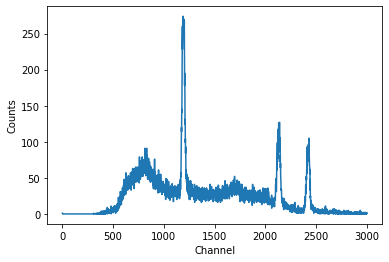

[274 count peak at 1189 between 1175 and 1207, 127 count peak at 2139 between 2116 and 2147, 105 count peak at 2430 between 2405 and 2439]
Energy(c) = 0.0c^2 + 0.5147c + 39.6161
17.529346009648936



k = 350, l = 750


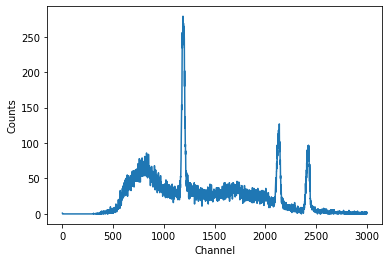

[279 count peak at 1188 between 1174 and 1206, 127 count peak at 2137 between 2114 and 2147, 97 count peak at 2424 between 2403 and 2434]
Energy(c) = 0.0c^2 + 0.4962c + 54.0238
17.452454484411874



k = 350, l = 800


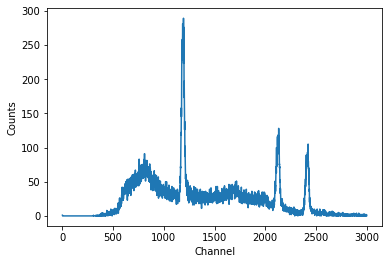

[289 count peak at 1193 between 1170 and 1203, 128 count peak at 2131 between 2108 and 2141, 105 count peak at 2421 between 2396 and 2427]
Energy(c) = 0.0c^2 + 0.5349c + 19.0752
17.680259687378605



k = 350, l = 850


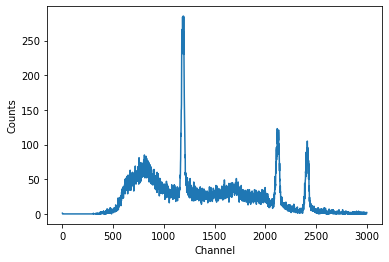

[285 count peak at 1188 between 1170 and 1202, 123 count peak at 2117 between 2106 and 2138, 105 count peak at 2413 between 2395 and 2425]
Energy(c) = -0.0c^2 + 0.5845c + -18.2422
17.096737205990127



k = 350, l = 900


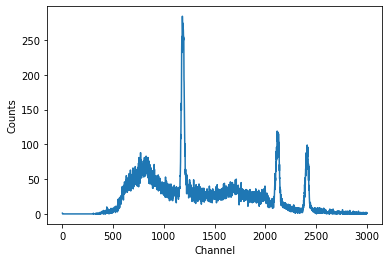

[284 count peak at 1182 between 1169 and 1201, 119 count peak at 2116 between 2105 and 2137, 99 count peak at 2412 between 2393 and 2424]
Energy(c) = -0.0c^2 + 0.5735c + -5.2138
17.218922422208113



k = 350, l = 950


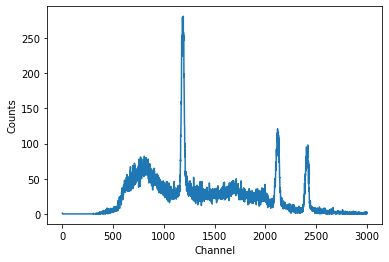

[281 count peak at 1191 between 1169 and 1202, 121 count peak at 2120 between 2105 and 2137, 98 count peak at 2418 between 2393 and 2424]
Energy(c) = -0.0c^2 + 0.5943c + -27.3846
17.420106525419328



k = 350, l = 1000


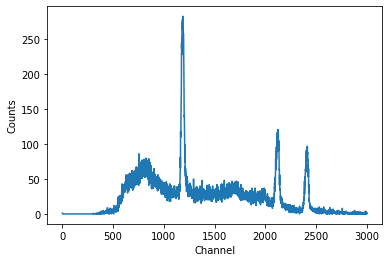

[283 count peak at 1186 between 1168 and 1199, 121 count peak at 2125 between 2102 and 2135, 97 count peak at 2413 between 2389 and 2425]
Energy(c) = 0.0c^2 + 0.5225c + 32.5452
18.282653339154233



k = 350, l = 1050


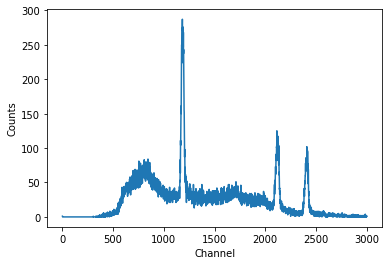

[287 count peak at 1182 between 1167 and 1200, 125 count peak at 2113 between 2102 and 2134, 102 count peak at 2408 between 2390 and 2421]
Energy(c) = -0.0c^2 + 0.5751c + -7.2153
17.46121797248558



k = 350, l = 1100


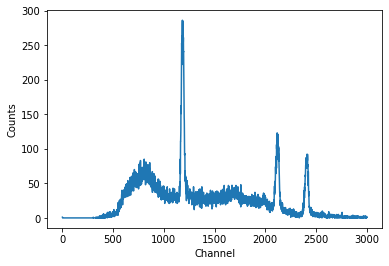

[286 count peak at 1182 between 1167 and 1200, 123 count peak at 2116 between 2102 and 2135, 92 count peak at 2408 between 2387 and 2424]
Energy(c) = -0.0c^2 + 0.5537c + 9.7589
18.769086295868494



k = 350, l = 1150


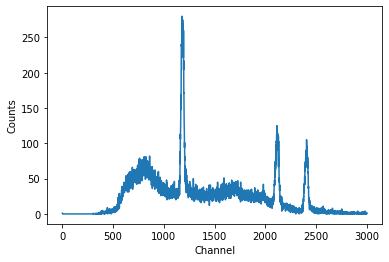

[280 count peak at 1180 between 1166 and 1199, 125 count peak at 2114 between 2100 and 2132, 105 count peak at 2406 between 2388 and 2421]
Energy(c) = -0.0c^2 + 0.5537c + 10.8663
17.860510709485272



k = 350, l = 1200


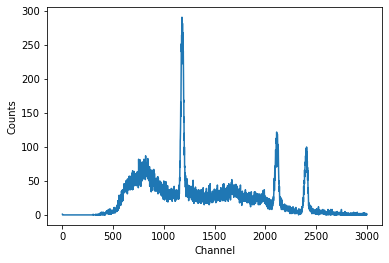

[291 count peak at 1178 between 1167 and 1196, 122 count peak at 2111 between 2095 and 2130, 100 count peak at 2406 between 2385 and 2417]
Energy(c) = -0.0c^2 + 0.5707c + -1.1292
17.42074994035204



k = 400, l = 200


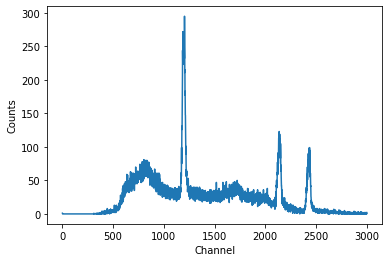

[295 count peak at 1203 between 1180 and 1211, 123 count peak at 2136 between 2121 and 2151, 99 count peak at 2435 between 2412 and 2444]
Energy(c) = -0.0c^2 + 0.5906c + -30.4084
16.797037742644687



k = 400, l = 250


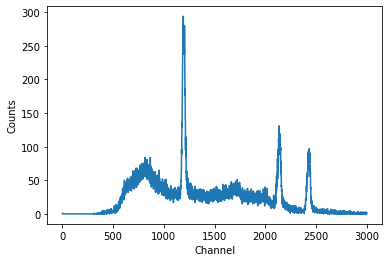

[294 count peak at 1191 between 1179 and 1210, 131 count peak at 2135 between 2124 and 2151, 97 count peak at 2432 between 2411 and 2444]
Energy(c) = -0.0c^2 + 0.557c + 4.7927
16.36568065403897



k = 400, l = 300


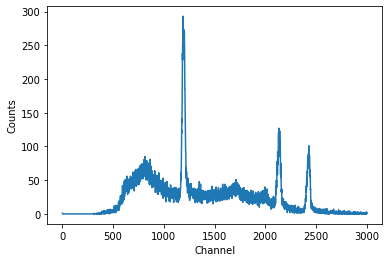

[293 count peak at 1190 between 1178 and 1209, 127 count peak at 2133 between 2119 and 2149, 101 count peak at 2430 between 2409 and 2441]
Energy(c) = -0.0c^2 + 0.5591c + 3.4857
16.735476879698997



k = 400, l = 350


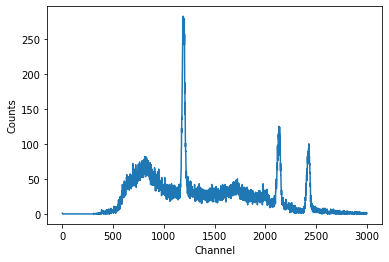

[282 count peak at 1189 between 1177 and 1209, 125 count peak at 2132 between 2118 and 2148, 100 count peak at 2428 between 2412 and 2440]
Energy(c) = -0.0c^2 + 0.5542c + 7.7411
16.224611448142053



k = 400, l = 400


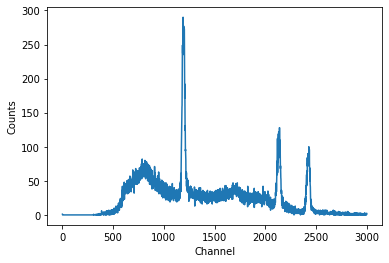

[290 count peak at 1189 between 1177 and 1208, 128 count peak at 2139 between 2120 and 2150, 100 count peak at 2428 between 2407 and 2438]
Energy(c) = 0.0c^2 + 0.5045c + 47.42
16.669043843091572



k = 400, l = 450


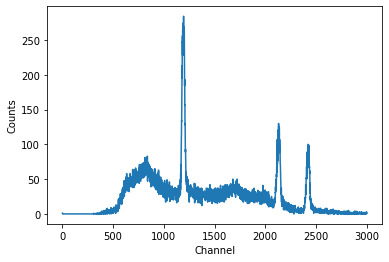

[284 count peak at 1194 between 1175 and 1207, 130 count peak at 2130 between 2116 and 2147, 100 count peak at 2422 between 2407 and 2438]
Energy(c) = -0.0c^2 + 0.5494c + 6.938
17.110286028521198



k = 400, l = 500


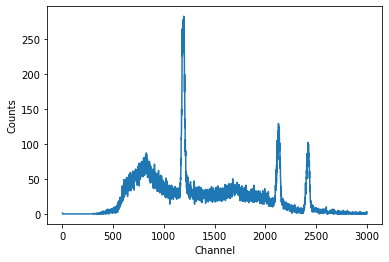

[282 count peak at 1196 between 1176 and 1206, 129 count peak at 2129 between 2117 and 2143, 102 count peak at 2421 between 2408 and 2433]
Energy(c) = -0.0c^2 + 0.556c + 0.0825
14.776877027469823



k = 400, l = 550


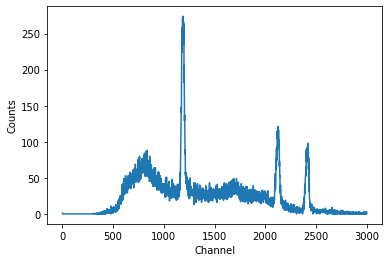

[274 count peak at 1190 between 1170 and 1202, 121 count peak at 2122 between 2108 and 2141, 98 count peak at 2417 between 2394 and 2426]
Energy(c) = -0.0c^2 + 0.5731c + -9.8954
17.62647736945769



k = 400, l = 600


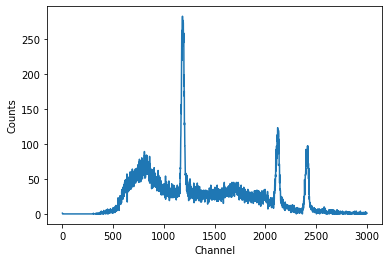

[282 count peak at 1183 between 1169 and 1201, 123 count peak at 2121 between 2103 and 2139, 97 count peak at 2418 between 2391 and 2427]
Energy(c) = -0.0c^2 + 0.5697c + -1.9176
18.761740357713318



k = 400, l = 650


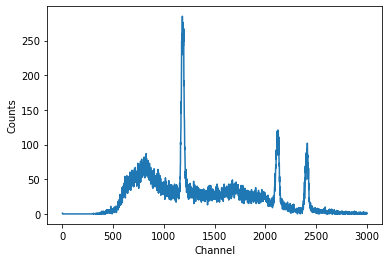

[285 count peak at 1182 between 1168 and 1200, 121 count peak at 2123 between 2100 and 2137, 102 count peak at 2413 between 2397 and 2422]
Energy(c) = 0.0c^2 + 0.5286c + 30.5509
17.0968690624469



k = 400, l = 700


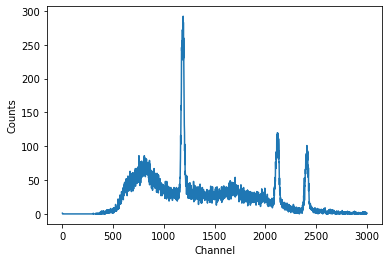

[292 count peak at 1190 between 1168 and 1200, 120 count peak at 2119 between 2099 and 2137, 101 count peak at 2409 between 2391 and 2424]
Energy(c) = -0.0c^2 + 0.5545c + 3.4892
18.88317202597803



k = 400, l = 750


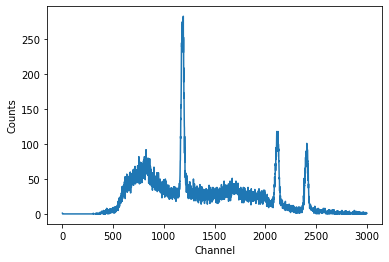

[283 count peak at 1191 between 1167 and 1199, 118 count peak at 2112 between 2101 and 2135, 101 count peak at 2408 between 2388 and 2420]
Energy(c) = -0.0c^2 + 0.6025c + -35.6496
17.906095549876415



k = 400, l = 800


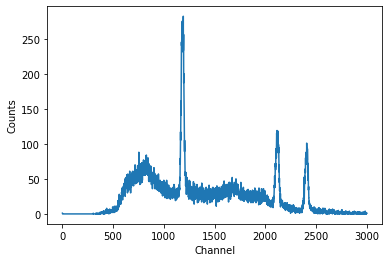

[282 count peak at 1191 between 1169 and 1200, 119 count peak at 2115 between 2101 and 2133, 101 count peak at 2407 between 2388 and 2420]
Energy(c) = -0.0c^2 + 0.5758c + -14.5786
17.421530215346138



k = 400, l = 850


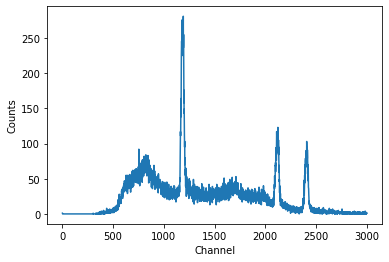

[281 count peak at 1191 between 1169 and 1200, 123 count peak at 2123 between 2101 and 2133, 103 count peak at 2407 between 2389 and 2420]
Energy(c) = 0.0c^2 + 0.5163c + 32.8452
17.34944284995989



k = 400, l = 900


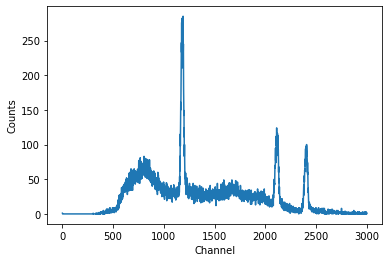

[285 count peak at 1189 between 1164 and 1196, 124 count peak at 2111 between 2097 and 2129, 100 count peak at 2406 between 2385 and 2418]
Energy(c) = -0.0c^2 + 0.5953c + -28.7413
17.737696975047584



k = 400, l = 950


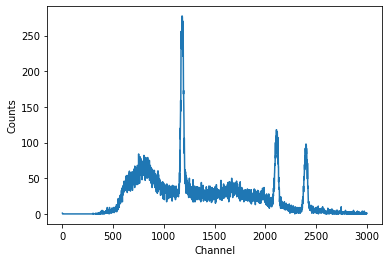

[277 count peak at 1181 between 1162 and 1196, 118 count peak at 2109 between 2091 and 2129, 98 count peak at 2400 between 2381 and 2414]
Energy(c) = -0.0c^2 + 0.5618c + 2.712
19.235442037345365



k = 400, l = 1000


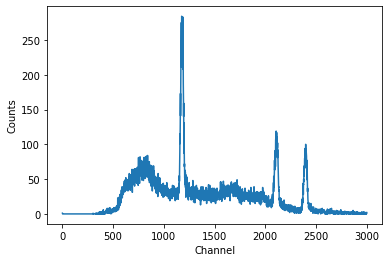

[284 count peak at 1175 between 1164 and 1193, 119 count peak at 2106 between 2091 and 2126, 100 count peak at 2397 between 2379 and 2410]
Energy(c) = -0.0c^2 + 0.5552c + 11.7746
17.36813639105613



k = 400, l = 1050


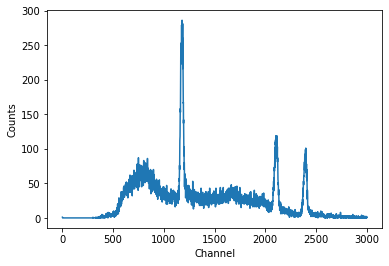

[286 count peak at 1179 between 1160 and 1192, 119 count peak at 2104 between 2086 and 2123, 101 count peak at 2398 between 2377 and 2409]
Energy(c) = -0.0c^2 + 0.5834c + -13.2634
18.45550750981613



k = 400, l = 1100


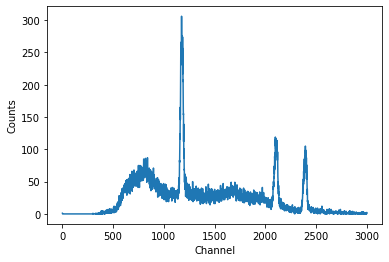

[306 count peak at 1174 between 1162 and 1193, 119 count peak at 2098 between 2088 and 2122, 105 count peak at 2394 between 2378 and 2409]
Energy(c) = -0.0c^2 + 0.5953c + -19.6176
17.501028805045127



k = 400, l = 1150


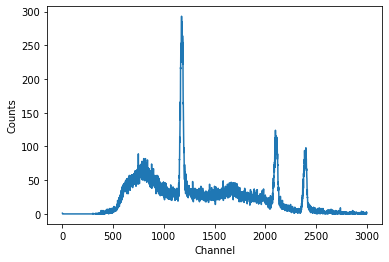

[293 count peak at 1174 between 1162 and 1192, 124 count peak at 2099 between 2088 and 2122, 98 count peak at 2399 between 2375 and 2409]
Energy(c) = -0.0c^2 + 0.6121c + -32.0292
17.72969126148185



k = 400, l = 1200


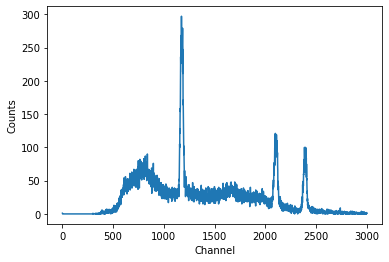

[297 count peak at 1173 between 1159 and 1192, 121 count peak at 2098 between 2087 and 2122, 100 count peak at 2395 between 2374 and 2408]
Energy(c) = -0.0c^2 + 0.5979c + -20.727
18.55593745568213



k = 450, l = 200


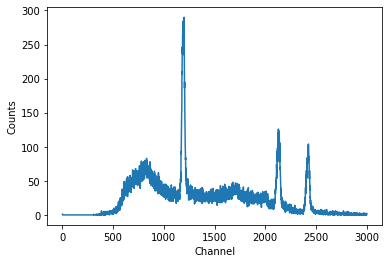

[290 count peak at 1199 between 1174 and 1206, 126 count peak at 2128 between 2114 and 2145, 104 count peak at 2424 between 2403 and 2435]
Energy(c) = -0.0c^2 + 0.5848c + -24.6733
17.275838904883205



k = 450, l = 250


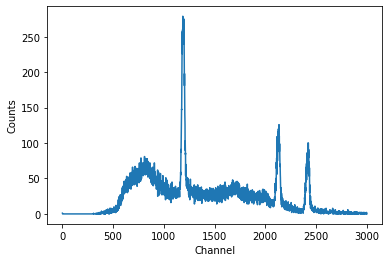

[279 count peak at 1186 between 1172 and 1206, 126 count peak at 2134 between 2113 and 2143, 100 count peak at 2419 between 2406 and 2435]
Energy(c) = 0.0c^2 + 0.4878c + 61.2323
16.93601597176185



k = 450, l = 300


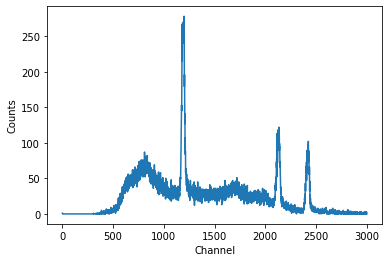

[278 count peak at 1199 between 1173 and 1205, 122 count peak at 2134 between 2113 and 2145, 102 count peak at 2423 between 2406 and 2434]
Energy(c) = 0.0c^2 + 0.5362c + 14.0975
16.82228290421699



k = 450, l = 350


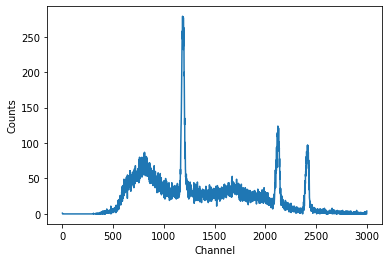

[279 count peak at 1184 between 1170 and 1203, 124 count peak at 2123 between 2111 and 2140, 97 count peak at 2418 between 2394 and 2426]
Energy(c) = -0.0c^2 + 0.5578c + 6.7652
17.009808710406144



k = 450, l = 400


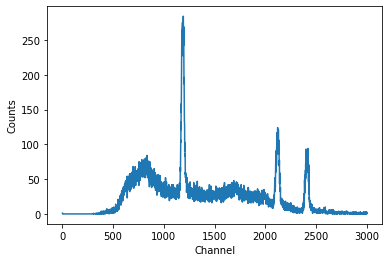

[284 count peak at 1191 between 1169 and 1201, 124 count peak at 2121 between 2106 and 2138, 94 count peak at 2418 between 2392 and 2424]
Energy(c) = -0.0c^2 + 0.5872c + -21.7715
17.421892111747525



k = 450, l = 450


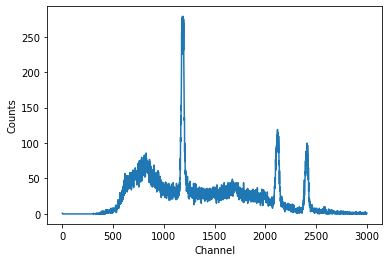

[279 count peak at 1187 between 1168 and 1200, 119 count peak at 2119 between 2104 and 2137, 100 count peak at 2412 between 2390 and 2422]
Energy(c) = -0.0c^2 + 0.5631c + -0.6396
17.675609860337357



k = 450, l = 500


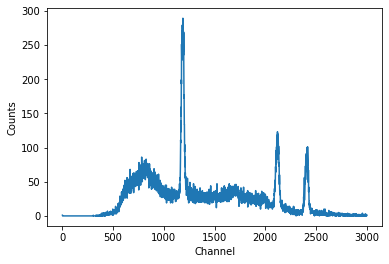

[289 count peak at 1187 between 1168 and 1200, 123 count peak at 2119 between 2102 and 2135, 101 count peak at 2416 between 2390 and 2422]
Energy(c) = -0.0c^2 + 0.5828c + -15.5867
17.578937378407733



k = 450, l = 550


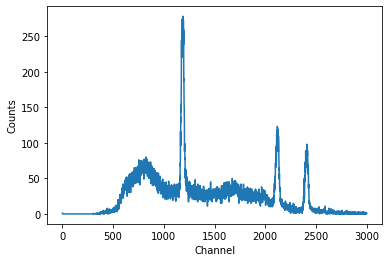

[278 count peak at 1186 between 1167 and 1200, 123 count peak at 2118 between 2101 and 2134, 98 count peak at 2408 between 2389 and 2423]
Energy(c) = 0.0c^2 + 0.5479c + 11.4557
18.299679805767596



k = 450, l = 600


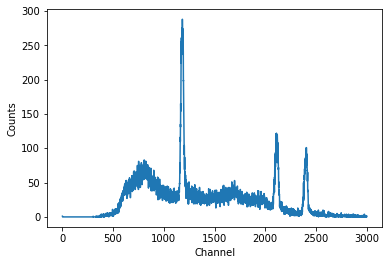

[288 count peak at 1182 between 1164 and 1196, 122 count peak at 2109 between 2095 and 2129, 101 count peak at 2404 between 2382 and 2416]
Energy(c) = -0.0c^2 + 0.5839c + -14.8808
18.220619013245557



k = 450, l = 650


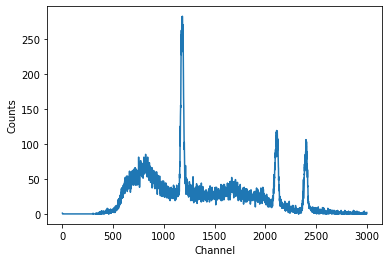

[282 count peak at 1182 between 1163 and 1196, 119 count peak at 2111 between 2094 and 2129, 106 count peak at 2400 between 2382 and 2413]
Energy(c) = 0.0c^2 + 0.5494c + 11.8158
18.17666818992753



k = 450, l = 700


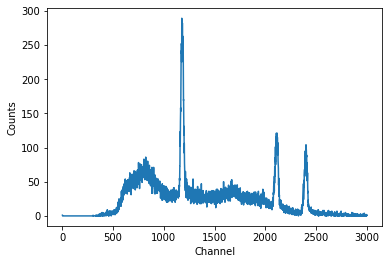

[289 count peak at 1176 between 1163 and 1196, 121 count peak at 2108 between 2094 and 2128, 104 count peak at 2400 between 2381 and 2412]
Energy(c) = -0.0c^2 + 0.558c + 9.3156
17.88418389232864



k = 450, l = 750


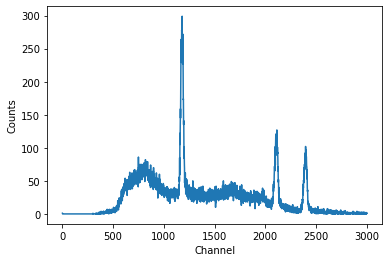

[299 count peak at 1180 between 1164 and 1193, 127 count peak at 2113 between 2092 and 2123, 102 count peak at 2396 between 2378 and 2411]
Energy(c) = 0.0c^2 + 0.509c + 44.5009
17.19817239277783



k = 450, l = 800


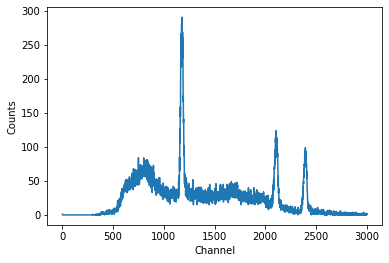

[291 count peak at 1179 between 1163 and 1192, 124 count peak at 2103 between 2086 and 2123, 99 count peak at 2394 between 2376 and 2410]
Energy(c) = -0.0c^2 + 0.5706c + -3.8584
18.352145689431797



k = 450, l = 850


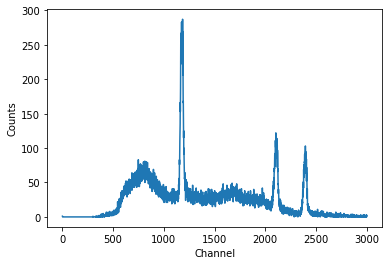

[287 count peak at 1184 between 1160 and 1193, 122 count peak at 2103 between 2085 and 2123, 103 count peak at 2394 between 2376 and 2409]
Energy(c) = -0.0c^2 + 0.5819c + -16.4986
19.15837632103114



k = 450, l = 900


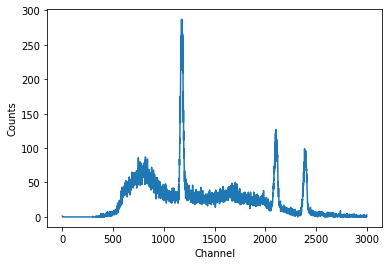

[287 count peak at 1174 between 1162 and 1191, 127 count peak at 2102 between 2089 and 2122, 99 count peak at 2386 between 2375 and 2408]
Energy(c) = 0.0c^2 + 0.5253c + 34.065
17.596857954205422



k = 450, l = 950


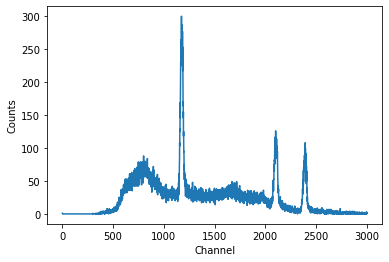

[300 count peak at 1173 between 1161 and 1190, 126 count peak at 2101 between 2088 and 2121, 108 count peak at 2392 between 2376 and 2402]
Energy(c) = -0.0c^2 + 0.5617c + 7.206
16.1227310410153



k = 450, l = 1000


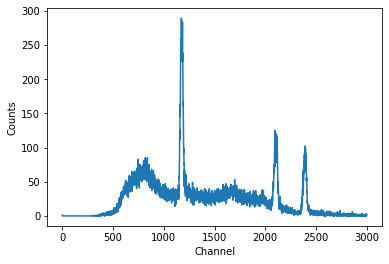

[289 count peak at 1172 between 1158 and 1191, 125 count peak at 2097 between 2085 and 2120, 102 count peak at 2391 between 2375 and 2404]
Energy(c) = -0.0c^2 + 0.5833c + -9.18
17.7378522128926



k = 450, l = 1050


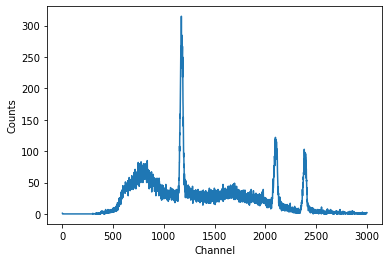

[315 count peak at 1172 between 1160 and 1189, 122 count peak at 2099 between 2085 and 2119, 103 count peak at 2383 between 2372 and 2405]
Energy(c) = 0.0c^2 + 0.5276c + 33.2176
17.79306552154185



k = 450, l = 1100


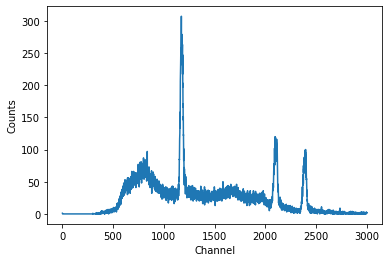

[307 count peak at 1172 between 1160 and 1189, 120 count peak at 2096 between 2084 and 2119, 100 count peak at 2396 between 2374 and 2406]
Energy(c) = -0.0c^2 + 0.6143c + -32.7227
17.378278270850426



k = 450, l = 1150


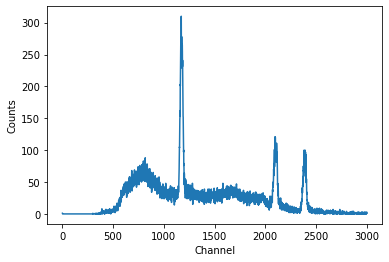

[310 count peak at 1171 between 1160 and 1188, 121 count peak at 2095 between 2083 and 2117, 100 count peak at 2391 between 2373 and 2402]
Energy(c) = -0.0c^2 + 0.5952c + -17.8318
16.580980267962218



k = 450, l = 1200


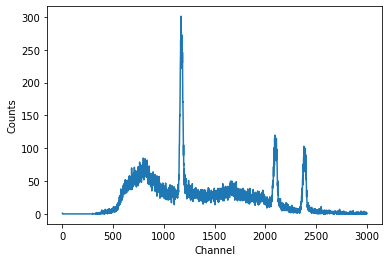

[301 count peak at 1170 between 1157 and 1187, 120 count peak at 2093 between 2081 and 2115, 103 count peak at 2379 between 2371 and 2401]
Energy(c) = 0.0c^2 + 0.547c + 18.6834
17.401302910139822



k = 500, l = 200


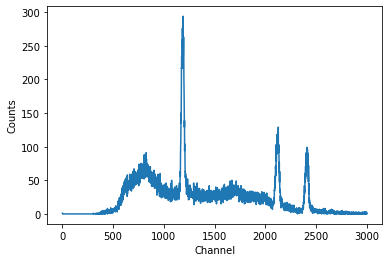

[294 count peak at 1190 between 1170 and 1200, 129 count peak at 2127 between 2105 and 2135, 99 count peak at 2410 between 2391 and 2423]
Energy(c) = 0.0c^2 + 0.5001c + 47.0112
16.958795862952



k = 500, l = 250


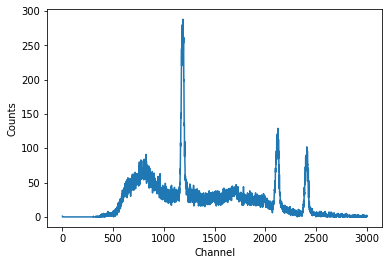

[288 count peak at 1189 between 1169 and 1199, 129 count peak at 2125 between 2103 and 2133, 102 count peak at 2408 between 2390 and 2423]
Energy(c) = 0.0c^2 + 0.5023c + 45.6211
17.1584552492277



k = 500, l = 300


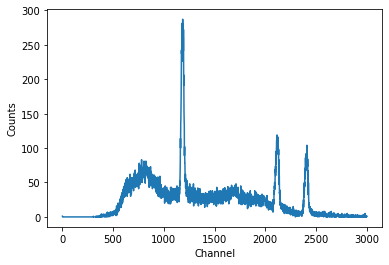

[287 count peak at 1185 between 1167 and 1198, 119 count peak at 2115 between 2101 and 2130, 104 count peak at 2409 between 2387 and 2419]
Energy(c) = -0.0c^2 + 0.5725c + -7.1132
16.762949206349237



k = 500, l = 350


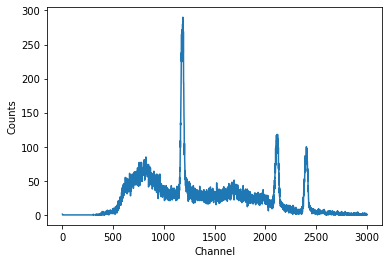

[290 count peak at 1187 between 1165 and 1197, 118 count peak at 2113 between 2098 and 2132, 100 count peak at 2404 between 2385 and 2417]
Energy(c) = -0.0c^2 + 0.5663c + -4.5312
17.975787809068418



k = 500, l = 400


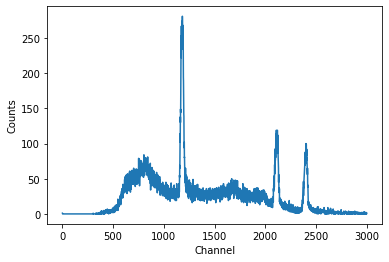

[281 count peak at 1182 between 1163 and 1196, 119 count peak at 2118 between 2094 and 2129, 100 count peak at 2400 between 2380 and 2415]
Energy(c) = 0.0c^2 + 0.497c + 53.267
19.031076455608627



k = 500, l = 450


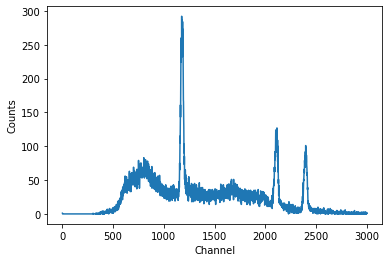

[292 count peak at 1175 between 1164 and 1194, 127 count peak at 2114 between 2092 and 2124, 101 count peak at 2397 between 2378 and 2412]
Energy(c) = 0.0c^2 + 0.4963c + 58.222
17.691527783070757



k = 500, l = 500


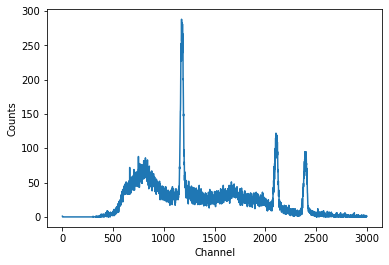

[288 count peak at 1174 between 1161 and 1194, 122 count peak at 2104 between 2090 and 2124, 95 count peak at 2389 between 2376 and 2409]
Energy(c) = 0.0c^2 + 0.5263c + 33.8367
18.45756932663528



k = 500, l = 550


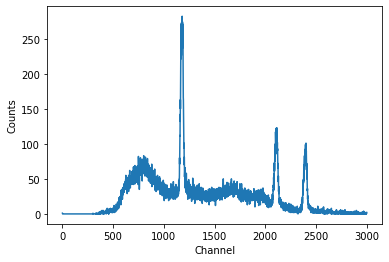

[282 count peak at 1180 between 1161 and 1194, 123 count peak at 2112 between 2090 and 2122, 101 count peak at 2400 between 2379 and 2408]
Energy(c) = 0.0c^2 + 0.5377c + 22.5351
17.244775813222645



k = 500, l = 600


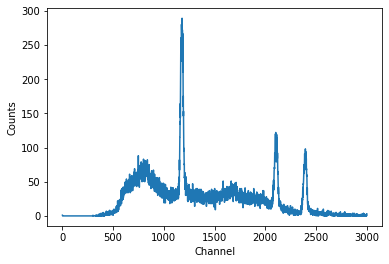

[289 count peak at 1179 between 1162 and 1193, 122 count peak at 2102 between 2085 and 2121, 98 count peak at 2394 between 2375 and 2409]
Energy(c) = -0.0c^2 + 0.5779c + -9.6059
18.52400635939144



k = 500, l = 650


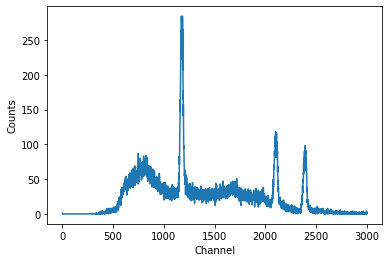

[284 count peak at 1172 between 1159 and 1190, 118 count peak at 2101 between 2083 and 2119, 98 count peak at 2392 between 2373 and 2407]
Energy(c) = -0.0c^2 + 0.5595c + 9.6635
18.486731843752448



k = 500, l = 700


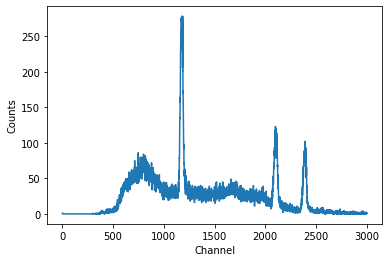

[278 count peak at 1185 between 1158 and 1191, 123 count peak at 2099 between 2085 and 2120, 102 count peak at 2390 between 2374 and 2400]
Energy(c) = -0.0c^2 + 0.5933c + -27.0079
17.398800663478557



k = 500, l = 750


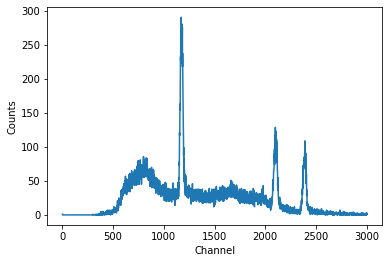

[291 count peak at 1171 between 1157 and 1189, 129 count peak at 2098 between 2083 and 2116, 109 count peak at 2389 between 2373 and 2399]
Energy(c) = -0.0c^2 + 0.5639c + 6.4311
16.688571123510695



k = 500, l = 800


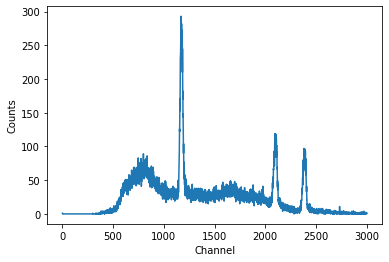

[293 count peak at 1170 between 1156 and 1187, 119 count peak at 2093 between 2078 and 2116, 97 count peak at 2379 between 2368 and 2402]
Energy(c) = 0.0c^2 + 0.547c + 18.6834
19.07028230304085



k = 500, l = 850


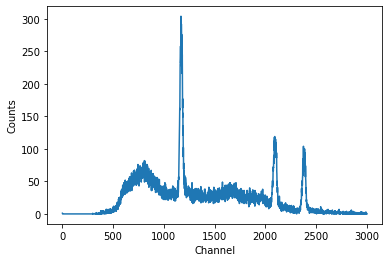

[304 count peak at 1168 between 1154 and 1185, 119 count peak at 2092 between 2075 and 2112, 104 count peak at 2375 between 2364 and 2398]
Energy(c) = 0.0c^2 + 0.5288c + 33.6541
18.96632035084906



k = 500, l = 900


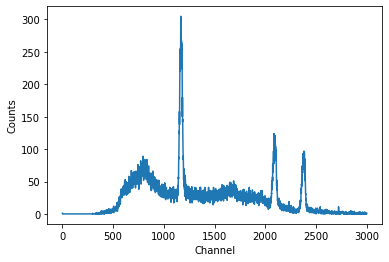

[305 count peak at 1166 between 1154 and 1181, 124 count peak at 2085 between 2074 and 2107, 97 count peak at 2380 between 2360 and 2393]
Energy(c) = -0.0c^2 + 0.6014c + -20.8259
16.9998807452093



k = 500, l = 950


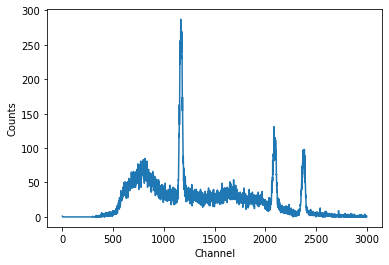

[287 count peak at 1166 between 1154 and 1184, 131 count peak at 2085 between 2076 and 2107, 98 count peak at 2384 between 2359 and 2393]
Energy(c) = -0.0c^2 + 0.6206c + -35.1318
17.281637894083246



k = 500, l = 1000


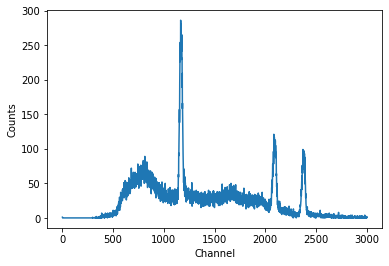

[286 count peak at 1165 between 1154 and 1184, 121 count peak at 2083 between 2073 and 2107, 99 count peak at 2370 between 2362 and 2391]
Energy(c) = -0.0c^2 + 0.5634c + 7.9204
17.2433510982875



k = 500, l = 1050


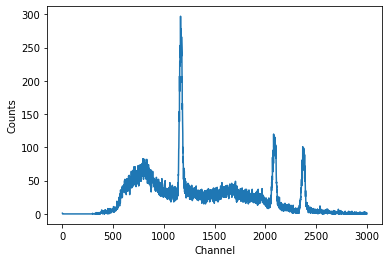

[297 count peak at 1164 between 1153 and 1182, 120 count peak at 2081 between 2072 and 2105, 101 count peak at 2368 between 2360 and 2389]
Energy(c) = -0.0c^2 + 0.5656c + 6.5524
16.88223822893436



k = 500, l = 1100


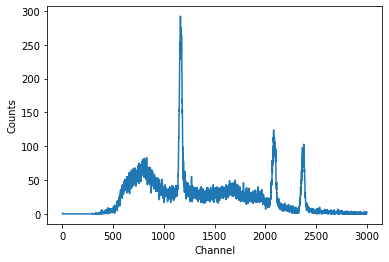

[292 count peak at 1163 between 1148 and 1182, 124 count peak at 2081 between 2069 and 2102, 103 count peak at 2379 between 2357 and 2387]
Energy(c) = -0.0c^2 + 0.618c + -31.6801
17.738842213147034



k = 500, l = 1150


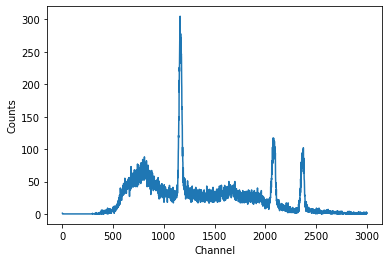

[305 count peak at 1160 between 1149 and 1178, 117 count peak at 2081 between 2064 and 2098, 102 count peak at 2374 between 2352 and 2383]
Energy(c) = -0.0c^2 + 0.587c + -6.1166
17.23646816793064



k = 500, l = 1200


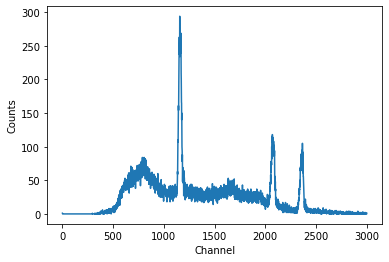

[294 count peak at 1156 between 1142 and 1174, 118 count peak at 2069 between 2057 and 2091, 105 count peak at 2365 between 2341 and 2374]
Energy(c) = -0.0c^2 + 0.6195c + -29.927
18.173715597768517



k = 550, l = 200


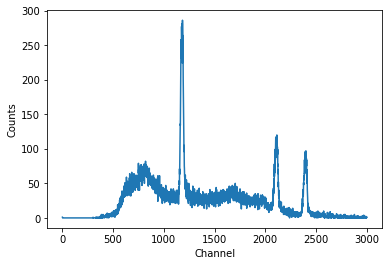

[286 count peak at 1183 between 1162 and 1194, 120 count peak at 2113 between 2089 and 2124, 97 count peak at 2399 between 2377 and 2412]
Energy(c) = 0.0c^2 + 0.5315c + 25.069
18.802735652957722



k = 550, l = 250


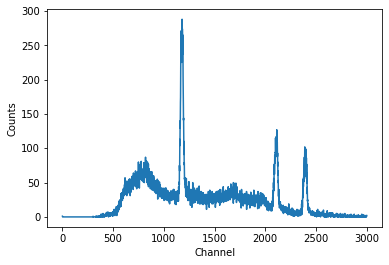

[288 count peak at 1179 between 1161 and 1192, 127 count peak at 2112 between 2090 and 2122, 102 count peak at 2388 between 2377 and 2407]
Energy(c) = 0.0c^2 + 0.4699c + 74.5788
17.35466353982095



k = 550, l = 300


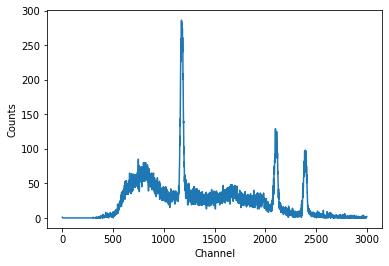

[286 count peak at 1173 between 1160 and 1192, 129 count peak at 2099 between 2089 and 2121, 98 count peak at 2394 between 2374 and 2409]
Energy(c) = -0.0c^2 + 0.586c + -11.535
18.046553878572087



k = 550, l = 350


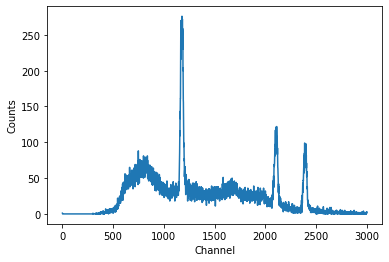

[276 count peak at 1178 between 1160 and 1193, 122 count peak at 2111 between 2084 and 2122, 99 count peak at 2387 between 2374 and 2409]
Energy(c) = 0.0c^2 + 0.47c + 75.0487
19.81826152857593



k = 550, l = 400


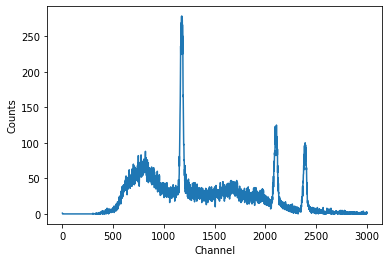

[278 count peak at 1174 between 1158 and 1192, 125 count peak at 2109 between 2087 and 2119, 100 count peak at 2392 between 2372 and 2407]
Energy(c) = 0.0c^2 + 0.5048c + 51.2954
18.633982567643937



k = 550, l = 450


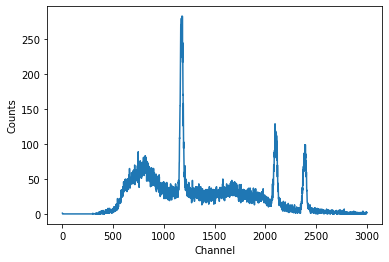

[283 count peak at 1176 between 1157 and 1189, 129 count peak at 2095 between 2085 and 2117, 99 count peak at 2394 between 2371 and 2405]
Energy(c) = -0.0c^2 + 0.621c + -41.3394
17.845949173766826



k = 550, l = 500


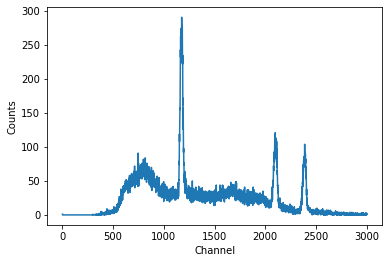

[291 count peak at 1175 between 1156 and 1188, 121 count peak at 2097 between 2082 and 2115, 104 count peak at 2387 between 2369 and 2403]
Energy(c) = -0.0c^2 + 0.57c + -1.6111
18.22842754060279



k = 550, l = 550


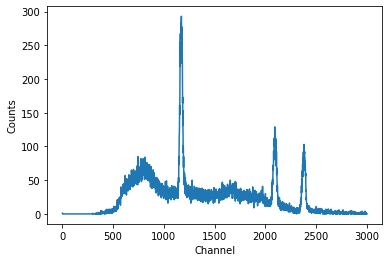

[293 count peak at 1172 between 1153 and 1185, 129 count peak at 2092 between 2079 and 2110, 103 count peak at 2381 between 2363 and 2397]
Energy(c) = -0.0c^2 + 0.5693c + 0.0757
17.909885857688817



k = 550, l = 600


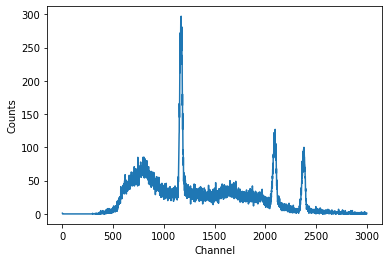

[297 count peak at 1170 between 1154 and 1183, 127 count peak at 2096 between 2076 and 2106, 100 count peak at 2380 between 2359 and 2393]
Energy(c) = 0.0c^2 + 0.5298c + 32.3742
17.24250621623465



k = 550, l = 650


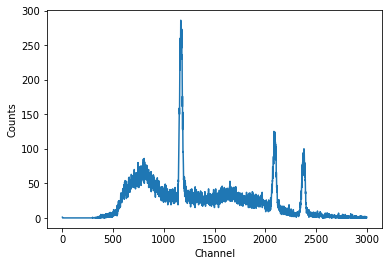

[286 count peak at 1166 between 1151 and 1183, 125 count peak at 2085 between 2073 and 2106, 100 count peak at 2380 between 2359 and 2393]
Energy(c) = -0.0c^2 + 0.6014c + -20.8259
18.127858781282082



k = 550, l = 700


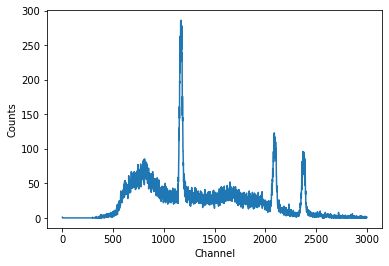

[286 count peak at 1170 between 1151 and 1183, 123 count peak at 2088 between 2073 and 2107, 96 count peak at 2370 between 2359 and 2391]
Energy(c) = 0.0c^2 + 0.5367c + 25.1145
18.30632804524176



k = 550, l = 750


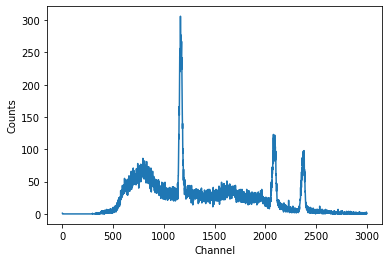

[306 count peak at 1163 between 1152 and 1181, 123 count peak at 2079 between 2069 and 2103, 98 count peak at 2380 between 2355 and 2387]
Energy(c) = -0.0c^2 + 0.6365c + -46.0142
17.25611657115856



k = 550, l = 800


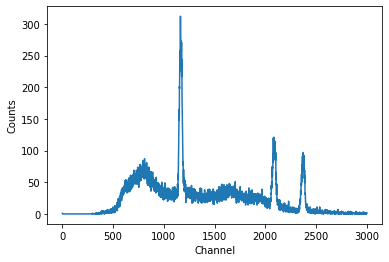

[312 count peak at 1163 between 1151 and 1180, 121 count peak at 2084 between 2069 and 2103, 97 count peak at 2373 between 2355 and 2387]
Energy(c) = -0.0c^2 + 0.567c + 7.1138
17.5250984724125



k = 550, l = 850


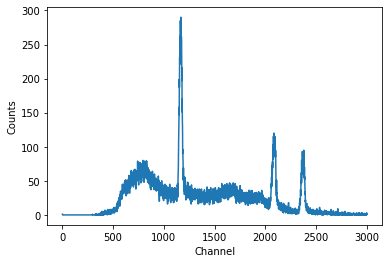

[290 count peak at 1167 between 1148 and 1181, 120 count peak at 2083 between 2068 and 2102, 95 count peak at 2378 between 2356 and 2388]
Energy(c) = -0.0c^2 + 0.6082c + -27.2488
18.179658310567522



k = 550, l = 900


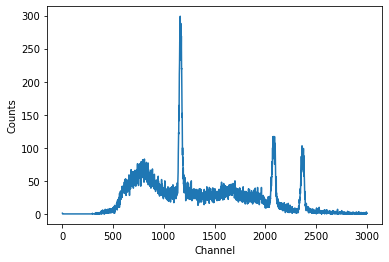

[299 count peak at 1161 between 1149 and 1178, 117 count peak at 2090 between 2065 and 2099, 103 count peak at 2361 between 2353 and 2383]
Energy(c) = 0.0c^2 + 0.4502c + 97.3817
17.571721689004978



k = 550, l = 950


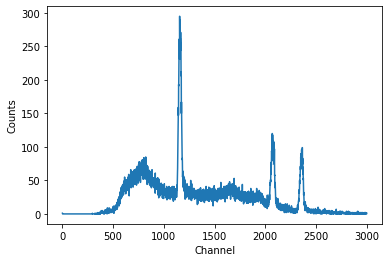

[295 count peak at 1155 between 1143 and 1174, 120 count peak at 2068 between 2056 and 2090, 99 count peak at 2364 between 2340 and 2374]
Energy(c) = -0.0c^2 + 0.6195c + -29.3075
18.158242313553654



k = 550, l = 1000


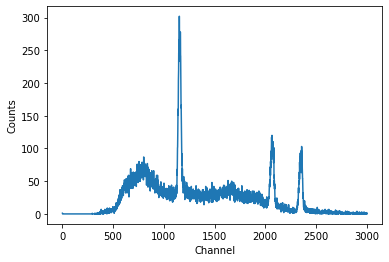

[302 count peak at 1152 between 1140 and 1170, 120 count peak at 2065 between 2050 and 2084, 103 count peak at 2357 between 2334 and 2367]
Energy(c) = -0.0c^2 + 0.5999c + -13.0434
17.89802237260926



k = 550, l = 1050


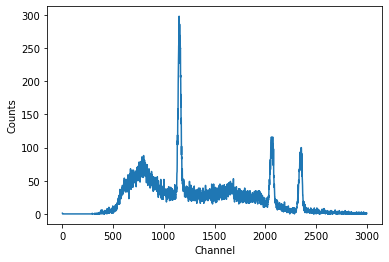

[298 count peak at 1150 between 1139 and 1168, 116 count peak at 2072 between 2047 and 2081, 100 count peak at 2354 between 2331 and 2364]
Energy(c) = 0.0c^2 + 0.5281c + 43.3952
17.899542171623164



k = 550, l = 1100


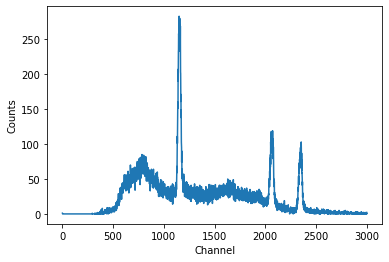

[283 count peak at 1150 between 1136 and 1168, 119 count peak at 2071 between 2046 and 2080, 103 count peak at 2353 between 2330 and 2362]
Energy(c) = 0.0c^2 + 0.5303c + 41.5167
18.26902311097611



k = 550, l = 1150


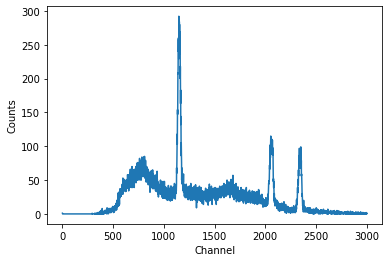

[292 count peak at 1147 between 1132 and 1165, 115 count peak at 2053 between 2039 and 2076, 99 count peak at 2349 between 2325 and 2358]
Energy(c) = -0.0c^2 + 0.6353c + -37.9027
18.994480437528978



k = 550, l = 1200


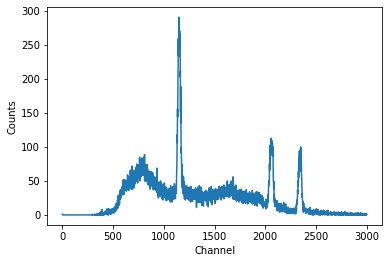

[291 count peak at 1147 between 1135 and 1165, 113 count peak at 2054 between 2039 and 2076, 100 count peak at 2348 between 2325 and 2358]
Energy(c) = -0.0c^2 + 0.6233c + -28.8562
18.45512051904393



k = 600, l = 200


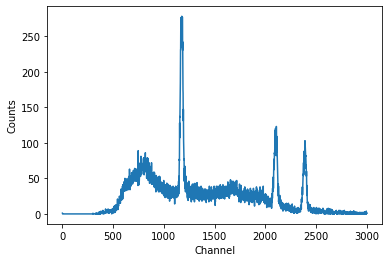

[278 count peak at 1176 between 1158 and 1190, 123 count peak at 2108 between 2087 and 2119, 103 count peak at 2390 between 2370 and 2405]
Energy(c) = 0.0c^2 + 0.5058c + 48.7537
18.338142586984947



k = 600, l = 250


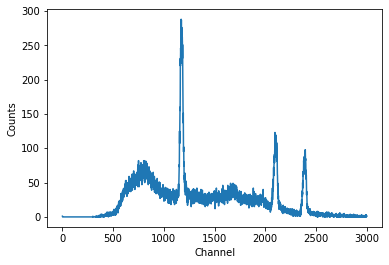

[288 count peak at 1170 between 1157 and 1189, 123 count peak at 2094 between 2083 and 2116, 98 count peak at 2393 between 2370 and 2404]
Energy(c) = -0.0c^2 + 0.6095c + -27.9746
17.967315023646204



k = 600, l = 300


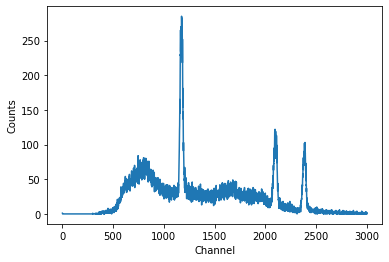

[285 count peak at 1174 between 1156 and 1187, 122 count peak at 2095 between 2080 and 2114, 103 count peak at 2390 between 2366 and 2399]
Energy(c) = -0.0c^2 + 0.5971c + -21.751
17.92142485895071



k = 600, l = 350


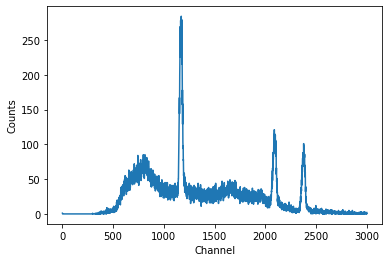

[284 count peak at 1171 between 1151 and 1183, 121 count peak at 2088 between 2073 and 2106, 101 count peak at 2377 between 2359 and 2393]
Energy(c) = -0.0c^2 + 0.576c + -5.1834
18.312316337258533



k = 600, l = 400


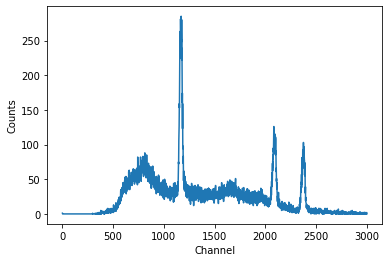

[285 count peak at 1169 between 1150 and 1182, 126 count peak at 2083 between 2074 and 2105, 103 count peak at 2375 between 2362 and 2391]
Energy(c) = -0.0c^2 + 0.598c + -21.2807
16.994378418681965



k = 600, l = 450


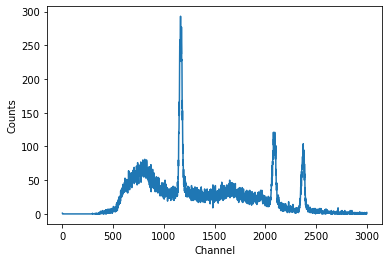

[293 count peak at 1164 between 1152 and 1181, 121 count peak at 2079 between 2069 and 2102, 104 count peak at 2373 between 2355 and 2383]
Energy(c) = -0.0c^2 + 0.6055c + -23.7242
16.55113581334543



k = 600, l = 500


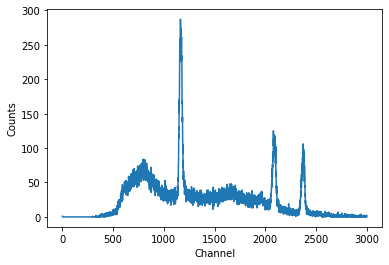

[287 count peak at 1163 between 1149 and 1181, 125 count peak at 2079 between 2069 and 2102, 106 count peak at 2373 between 2357 and 2383]
Energy(c) = -0.0c^2 + 0.6032c + -21.1773
16.753037746718064



k = 600, l = 550


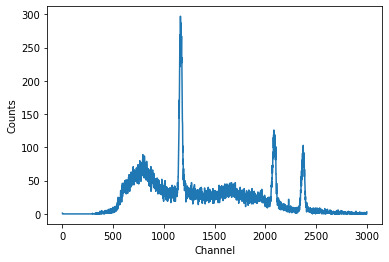

[297 count peak at 1163 between 1151 and 1181, 126 count peak at 2084 between 2069 and 2102, 103 count peak at 2373 between 2357 and 2388]
Energy(c) = -0.0c^2 + 0.567c + 7.1138
17.343825131668382



k = 600, l = 600


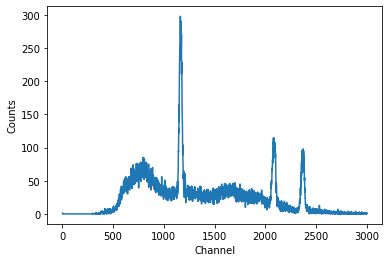

[298 count peak at 1162 between 1150 and 1180, 115 count peak at 2082 between 2064 and 2102, 98 count peak at 2373 between 2352 and 2386]
Energy(c) = -0.0c^2 + 0.5793c + -1.782
18.764259167452867



k = 600, l = 650


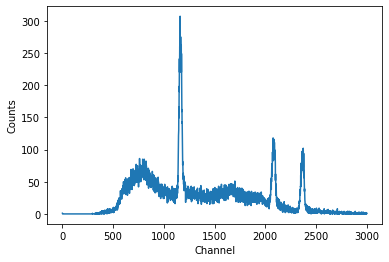

[307 count peak at 1160 between 1148 and 1178, 118 count peak at 2076 between 2064 and 2098, 102 count peak at 2373 between 2350 and 2382]
Energy(c) = -0.0c^2 + 0.6176c + -30.1486
17.55248431262881



k = 600, l = 700


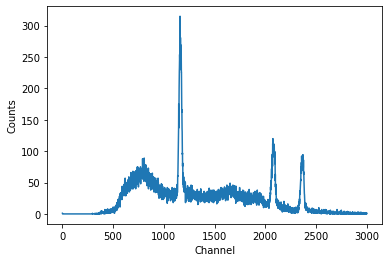

[315 count peak at 1159 between 1147 and 1177, 120 count peak at 2074 between 2062 and 2096, 94 count peak at 2371 between 2345 and 2381]
Energy(c) = -0.0c^2 + 0.6199c + -31.4639
18.271582120397778



k = 600, l = 750


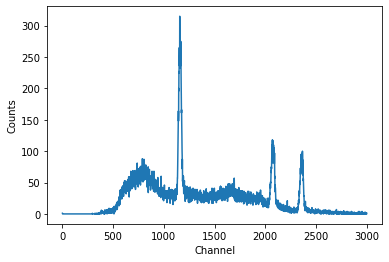

[315 count peak at 1156 between 1144 and 1174, 118 count peak at 2069 between 2054 and 2091, 100 count peak at 2365 between 2341 and 2374]
Energy(c) = -0.0c^2 + 0.6195c + -29.927
18.332687053402157



k = 600, l = 800


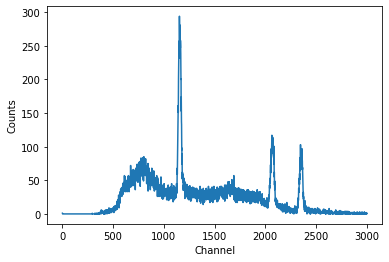

[294 count peak at 1153 between 1139 and 1171, 117 count peak at 2064 between 2052 and 2086, 103 count peak at 2346 between 2338 and 2369]
Energy(c) = 0.0c^2 + 0.5527c + 20.8002
18.199437226088055



k = 600, l = 850


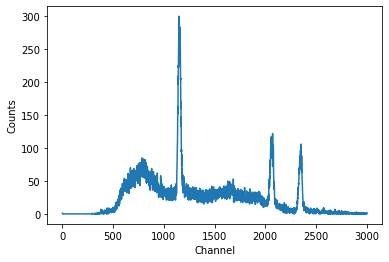

[300 count peak at 1150 between 1136 and 1168, 122 count peak at 2071 between 2046 and 2080, 106 count peak at 2353 between 2330 and 2361]
Energy(c) = 0.0c^2 + 0.5303c + 41.5167
18.079992250707807



k = 600, l = 900


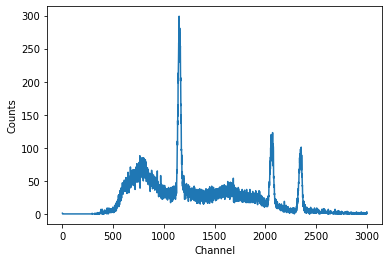

[299 count peak at 1150 between 1138 and 1168, 123 count peak at 2071 between 2046 and 2080, 101 count peak at 2353 between 2330 and 2363]
Energy(c) = 0.0c^2 + 0.5303c + 41.5167
18.09270178744676



k = 600, l = 950


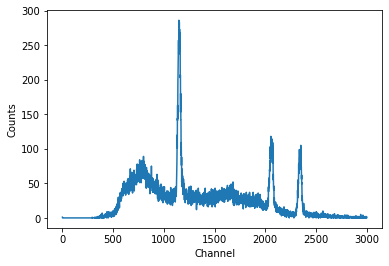

[286 count peak at 1148 between 1134 and 1166, 118 count peak at 2054 between 2039 and 2076, 105 count peak at 2349 between 2326 and 2357]
Energy(c) = -0.0c^2 + 0.6305c + -35.0004
18.47125146952025



k = 600, l = 1000


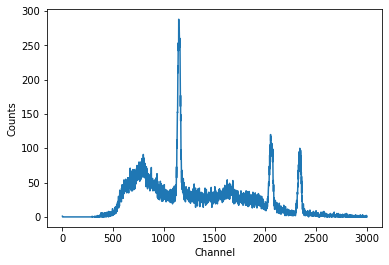

[288 count peak at 1146 between 1131 and 1164, 120 count peak at 2051 between 2041 and 2074, 100 count peak at 2339 between 2323 and 2354]
Energy(c) = -0.0c^2 + 0.598c + -10.1314
18.117076433893885



k = 600, l = 1050


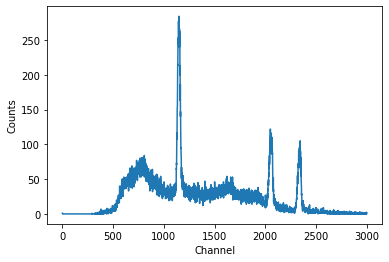

[284 count peak at 1149 between 1130 and 1162, 122 count peak at 2049 between 2037 and 2071, 105 count peak at 2343 between 2319 and 2351]
Energy(c) = -0.0c^2 + 0.6397c + -43.8989
18.201623893719102



k = 600, l = 1100


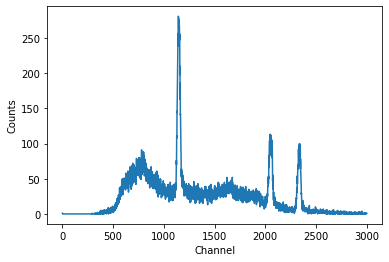

[281 count peak at 1143 between 1128 and 1163, 113 count peak at 2050 between 2032 and 2070, 100 count peak at 2336 between 2317 and 2350]
Energy(c) = -0.0c^2 + 0.583c + 3.107
19.82467332550088



k = 600, l = 1150


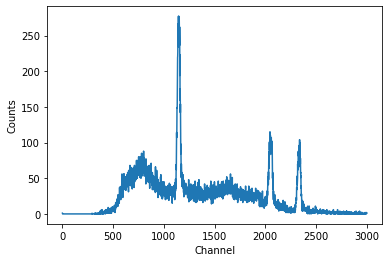

[277 count peak at 1143 between 1128 and 1163, 115 count peak at 2045 between 2031 and 2068, 104 count peak at 2337 between 2317 and 2348]
Energy(c) = -0.0c^2 + 0.625c + -28.9411
19.17946548697891



k = 600, l = 1200


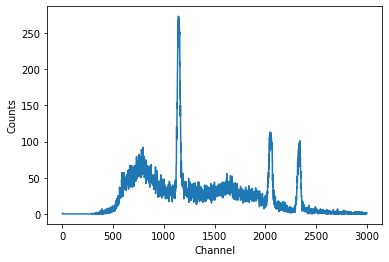

[273 count peak at 1143 between 1128 and 1161, 113 count peak at 2047 between 2031 and 2069, 101 count peak at 2340 between 2317 and 2348]
Energy(c) = -0.0c^2 + 0.6252c + -28.6283
18.925025665754827



k = 650, l = 200


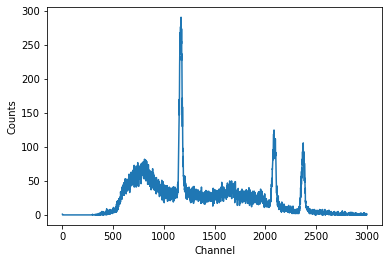

[291 count peak at 1169 between 1150 and 1181, 125 count peak at 2085 between 2069 and 2103, 106 count peak at 2373 between 2357 and 2383]
Energy(c) = -0.0c^2 + 0.5731c + -2.1184
16.877180230140084



k = 650, l = 250


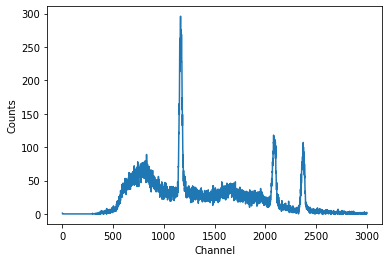

[296 count peak at 1164 between 1149 and 1181, 118 count peak at 2081 between 2069 and 2102, 107 count peak at 2373 between 2355 and 2388]
Energy(c) = -0.0c^2 + 0.5911c + -12.4615
18.048954616863284



k = 650, l = 300


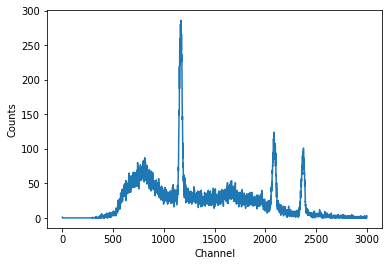

[286 count peak at 1167 between 1149 and 1181, 124 count peak at 2084 between 2069 and 2102, 101 count peak at 2375 between 2354 and 2386]
Energy(c) = -0.0c^2 + 0.5862c + -10.4821
17.89541832878577



k = 650, l = 350


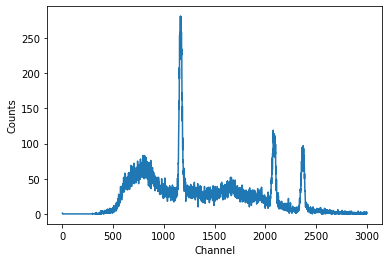

[281 count peak at 1162 between 1148 and 1180, 119 count peak at 2077 between 2069 and 2101, 97 count peak at 2373 between 2353 and 2386]
Energy(c) = -0.0c^2 + 0.6152c + -29.7507
17.786123664014212



k = 650, l = 400


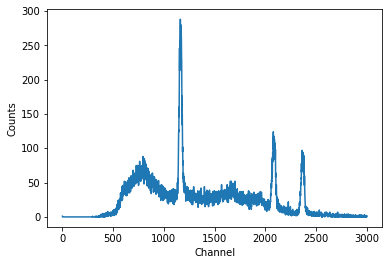

[288 count peak at 1162 between 1147 and 1179, 124 count peak at 2078 between 2068 and 2100, 97 count peak at 2362 between 2352 and 2383]
Energy(c) = 0.0c^2 + 0.5521c + 17.5294
17.714400330517833



k = 650, l = 450


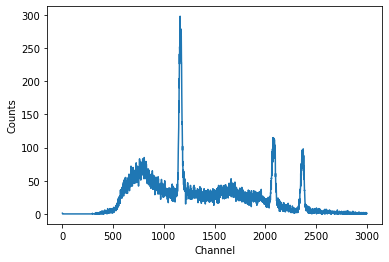

[298 count peak at 1160 between 1146 and 1178, 115 count peak at 2079 between 2064 and 2098, 98 count peak at 2373 between 2349 and 2382]
Energy(c) = -0.0c^2 + 0.5964c + -13.5944
18.15805550616714



k = 650, l = 500


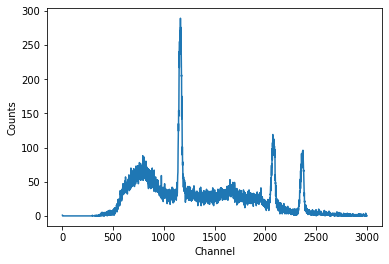

[289 count peak at 1163 between 1144 and 1176, 119 count peak at 2073 between 2061 and 2095, 96 count peak at 2370 between 2346 and 2379]
Energy(c) = -0.0c^2 + 0.6315c + -43.7301
18.184711811358966



k = 650, l = 550


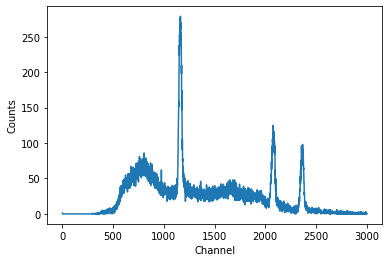

[279 count peak at 1163 between 1144 and 1178, 125 count peak at 2073 between 2061 and 2095, 98 count peak at 2367 between 2348 and 2379]
Energy(c) = -0.0c^2 + 0.617c + -32.9019
18.287658990179352



k = 650, l = 600


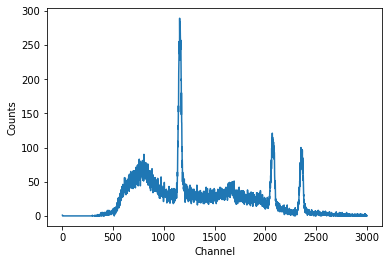

[289 count peak at 1155 between 1141 and 1173, 121 count peak at 2068 between 2055 and 2089, 100 count peak at 2350 between 2340 and 2374]
Energy(c) = 0.0c^2 + 0.5482c + 23.5694
18.74206407963129



k = 650, l = 650


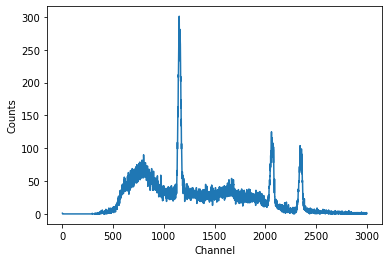

[301 count peak at 1151 between 1139 and 1169, 125 count peak at 2060 between 2048 and 2082, 104 count peak at 2342 between 2332 and 2363]
Energy(c) = 0.0c^2 + 0.5573c + 18.0288
17.848490068007475



k = 650, l = 700


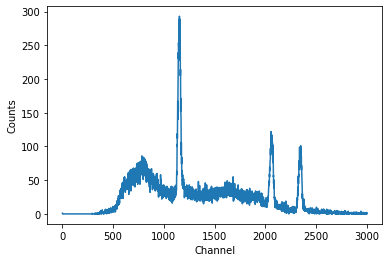

[293 count peak at 1153 between 1137 and 1167, 122 count peak at 2056 between 2044 and 2078, 101 count peak at 2348 between 2327 and 2359]
Energy(c) = -0.0c^2 + 0.623c + -33.2078
17.82684417078114



k = 650, l = 750


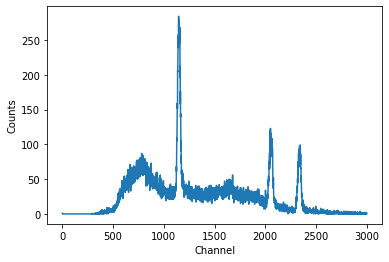

[284 count peak at 1145 between 1130 and 1163, 123 count peak at 2050 between 2042 and 2071, 99 count peak at 2343 between 2320 and 2351]
Energy(c) = -0.0c^2 + 0.623c + -27.9227
17.265129508507965



k = 650, l = 800


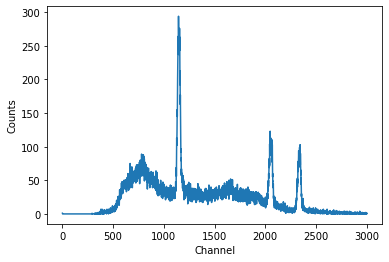

[294 count peak at 1144 between 1132 and 1162, 123 count peak at 2047 between 2034 and 2070, 103 count peak at 2342 between 2319 and 2350]
Energy(c) = -0.0c^2 + 0.6373c + -38.3411
17.932883284714006



k = 650, l = 850


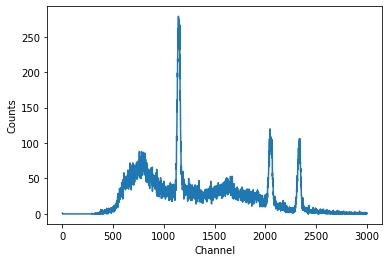

[279 count peak at 1143 between 1128 and 1163, 120 count peak at 2046 between 2032 and 2068, 106 count peak at 2335 between 2317 and 2348]
Energy(c) = -0.0c^2 + 0.6076c + -15.9752
19.05739608300223



k = 650, l = 900


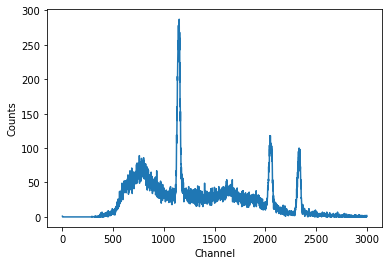

[287 count peak at 1151 between 1131 and 1161, 118 count peak at 2045 between 2031 and 2068, 100 count peak at 2332 between 2316 and 2347]
Energy(c) = -0.0c^2 + 0.6189c + -31.2624
18.439102700292324



k = 650, l = 950


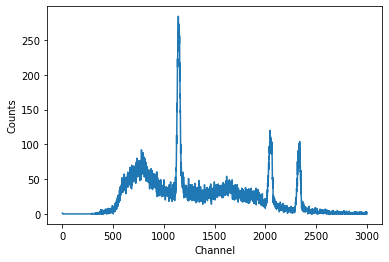

[284 count peak at 1142 between 1127 and 1162, 120 count peak at 2045 between 2033 and 2066, 104 count peak at 2338 between 2315 and 2346]
Energy(c) = -0.0c^2 + 0.6275c + -29.9574
18.410430305181496



k = 650, l = 1000


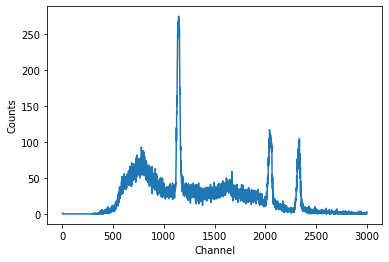

[275 count peak at 1145 between 1125 and 1159, 117 count peak at 2041 between 2027 and 2065, 105 count peak at 2335 between 2312 and 2343]
Energy(c) = -0.0c^2 + 0.649c + -49.3015
19.197904009103734



k = 650, l = 1050


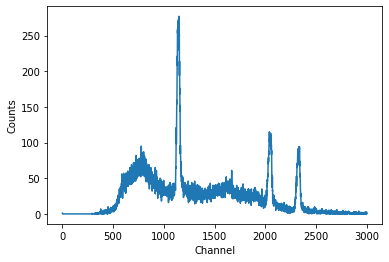

[277 count peak at 1148 between 1124 and 1159, 115 count peak at 2039 between 2025 and 2062, 94 count peak at 2333 between 2308 and 2342]
Energy(c) = -0.0c^2 + 0.6612c + -61.3566
19.81671409750834



k = 650, l = 1100


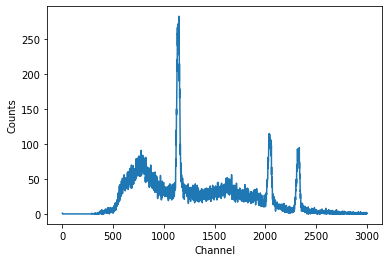

[283 count peak at 1147 between 1123 and 1158, 115 count peak at 2037 between 2023 and 2059, 95 count peak at 2334 between 2307 and 2340]
Energy(c) = -0.0c^2 + 0.678c + -73.3366
19.394785620983686



k = 650, l = 1150


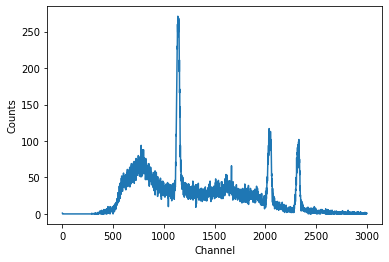

[271 count peak at 1137 between 1123 and 1156, 117 count peak at 2037 between 2022 and 2059, 102 count peak at 2330 between 2306 and 2340]
Energy(c) = -0.0c^2 + 0.6343c + -32.6792
19.32859938907522



k = 650, l = 1200


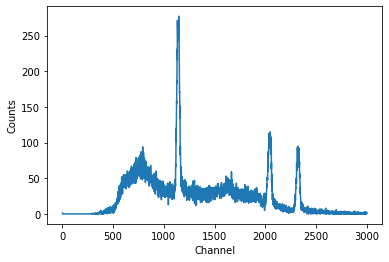

[277 count peak at 1146 between 1123 and 1156, 115 count peak at 2047 between 2025 and 2060, 95 count peak at 2323 between 2306 and 2340]
Energy(c) = 0.0c^2 + 0.5425c + 29.6326
19.435986437440306



k = 700, l = 200


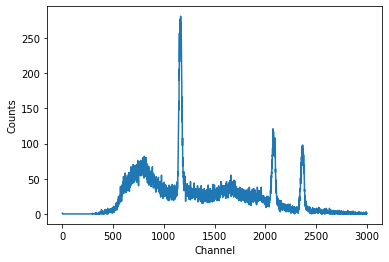

[281 count peak at 1165 between 1146 and 1178, 121 count peak at 2075 between 2064 and 2097, 98 count peak at 2367 between 2349 and 2382]
Energy(c) = -0.0c^2 + 0.6071c + -26.7421
18.129753159356255



k = 700, l = 250


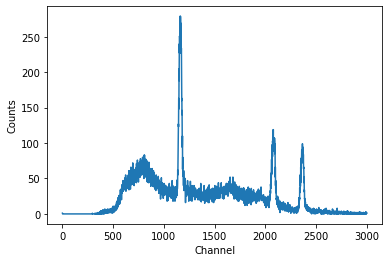

[279 count peak at 1163 between 1144 and 1179, 119 count peak at 2078 between 2062 and 2096, 99 count peak at 2365 between 2347 and 2379]
Energy(c) = -0.0c^2 + 0.5702c + 3.2444
18.76804086922827



k = 700, l = 300


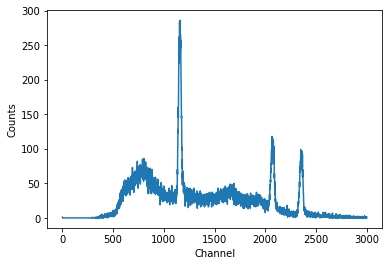

[286 count peak at 1159 between 1140 and 1174, 118 count peak at 2065 between 2052 and 2087, 99 count peak at 2348 between 2337 and 2371]
Energy(c) = -0.0c^2 + 0.5696c + 3.6442
19.358170977022116



k = 700, l = 350


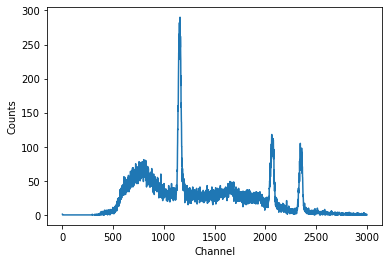

[290 count peak at 1159 between 1138 and 1171, 118 count peak at 2063 between 2050 and 2084, 105 count peak at 2344 between 2336 and 2367]
Energy(c) = 0.0c^2 + 0.5633c + 7.7493
18.49660985482035



k = 700, l = 400


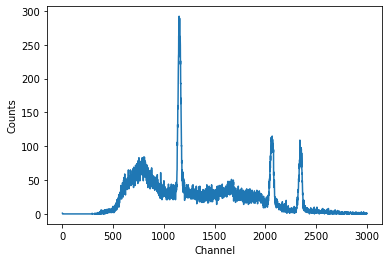

[292 count peak at 1150 between 1136 and 1168, 115 count peak at 2067 between 2044 and 2080, 109 count peak at 2340 between 2332 and 2362]
Energy(c) = 0.0c^2 + 0.4887c + 71.2486
18.564175570968207



k = 700, l = 450


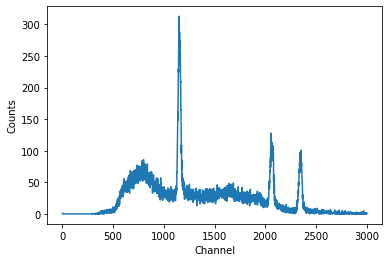

[313 count peak at 1150 between 1138 and 1168, 128 count peak at 2058 between 2046 and 2080, 101 count peak at 2353 between 2329 and 2362]
Energy(c) = -0.0c^2 + 0.626c + -32.3511
17.86981307049958



k = 700, l = 500


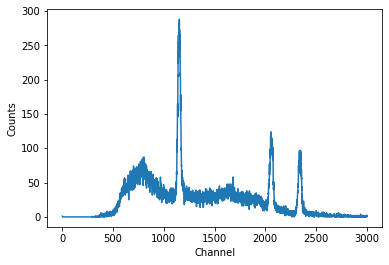

[288 count peak at 1152 between 1133 and 1166, 124 count peak at 2054 between 2041 and 2075, 97 count peak at 2345 between 2324 and 2358]
Energy(c) = -0.0c^2 + 0.6203c + -30.886
18.809219914761268



k = 700, l = 550


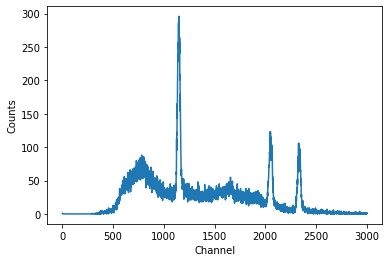

[296 count peak at 1148 between 1132 and 1161, 123 count peak at 2050 between 2032 and 2069, 106 count peak at 2327 between 2317 and 2348]
Energy(c) = 0.0c^2 + 0.5458c + 26.3459
18.453295589904695



k = 700, l = 600


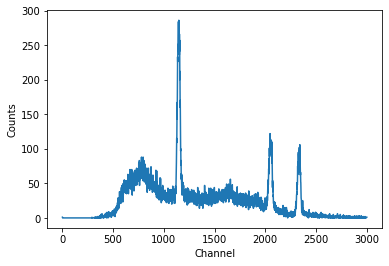

[286 count peak at 1147 between 1131 and 1162, 122 count peak at 2046 between 2038 and 2067, 106 count peak at 2339 between 2316 and 2347]
Energy(c) = -0.0c^2 + 0.6371c + -41.0117
16.945785753792432



k = 700, l = 650


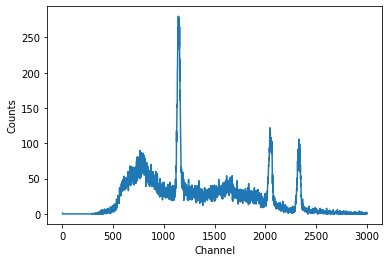

[280 count peak at 1142 between 1127 and 1162, 122 count peak at 2045 between 2030 and 2066, 106 count peak at 2333 between 2315 and 2346]
Energy(c) = -0.0c^2 + 0.6025c + -11.6408
19.08296706782346



k = 700, l = 700


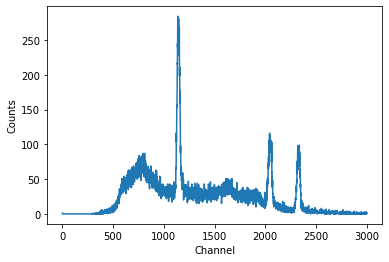

[284 count peak at 1140 between 1125 and 1159, 116 count peak at 2042 between 2027 and 2063, 99 count peak at 2334 between 2311 and 2344]
Energy(c) = -0.0c^2 + 0.6249c + -27.0663
19.163329893874636



k = 700, l = 750


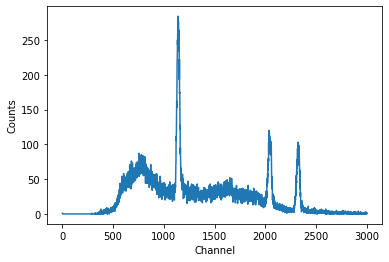

[284 count peak at 1138 between 1124 and 1158, 120 count peak at 2037 between 2027 and 2060, 103 count peak at 2323 between 2307 and 2338]
Energy(c) = -0.0c^2 + 0.6015c + -9.5461
18.432648730839748



k = 700, l = 800


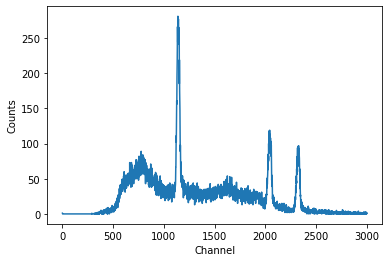

[281 count peak at 1138 between 1123 and 1158, 119 count peak at 2042 between 2027 and 2060, 97 count peak at 2327 between 2307 and 2338]
Energy(c) = -0.0c^2 + 0.5846c + 4.0266
18.58657119214585



k = 700, l = 850


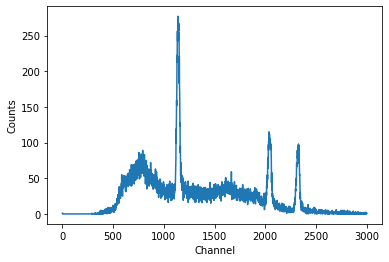

[277 count peak at 1137 between 1122 and 1157, 115 count peak at 2036 between 2021 and 2059, 98 count peak at 2326 between 2305 and 2338]
Energy(c) = -0.0c^2 + 0.6219c + -23.8193
19.81749430538802



k = 700, l = 900


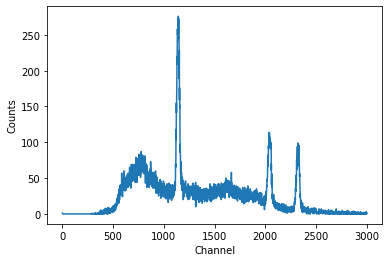

[276 count peak at 1142 between 1122 and 1157, 114 count peak at 2035 between 2021 and 2059, 99 count peak at 2321 between 2305 and 2338]
Energy(c) = -0.0c^2 + 0.6158c + -23.9048
20.00842786076741



k = 700, l = 950


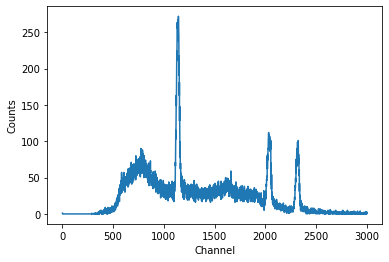

[272 count peak at 1143 between 1120 and 1153, 112 count peak at 2032 between 2017 and 2053, 101 count peak at 2324 between 2301 and 2334]
Energy(c) = -0.0c^2 + 0.656c + -54.9232
19.135156389561644



k = 700, l = 1000


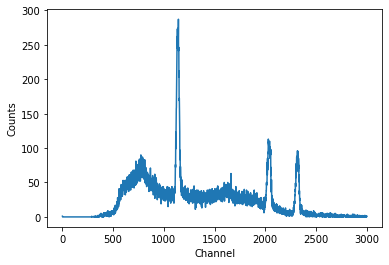

[287 count peak at 1143 between 1121 and 1153, 113 count peak at 2029 between 2016 and 2054, 96 count peak at 2316 between 2299 and 2333]
Energy(c) = -0.0c^2 + 0.638c + -42.5296
19.664071918846428



k = 700, l = 1050


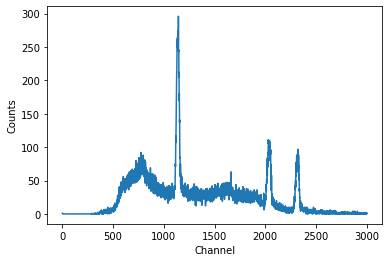

[296 count peak at 1143 between 1121 and 1153, 111 count peak at 2029 between 2019 and 2054, 97 count peak at 2323 between 2298 and 2333]
Energy(c) = -0.0c^2 + 0.6731c + -68.2343
19.087586489504776



k = 700, l = 1100


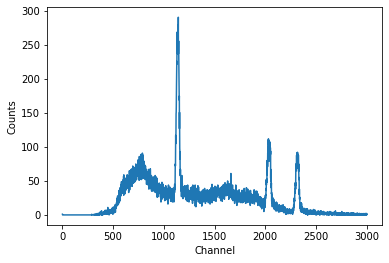

[291 count peak at 1142 between 1119 and 1152, 112 count peak at 2030 between 2015 and 2051, 92 count peak at 2314 between 2298 and 2332]
Energy(c) = -0.0c^2 + 0.6173c + -26.321
19.551812999042



k = 700, l = 1150


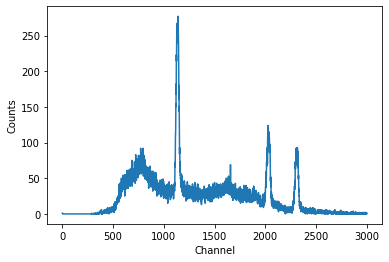

[277 count peak at 1140 between 1116 and 1151, 124 count peak at 2025 between 2011 and 2047, 93 count peak at 2309 between 2293 and 2327]
Energy(c) = -0.0c^2 + 0.6246c + -31.2012
19.983646116563097



k = 700, l = 1200


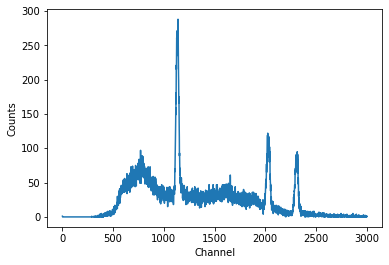

[288 count peak at 1139 between 1116 and 1150, 122 count peak at 2023 between 2009 and 2045, 95 count peak at 2314 between 2291 and 2325]
Energy(c) = -0.0c^2 + 0.663c + -58.8672
19.605562145597826





In [56]:
k_vals = np.linspace(100,700,int(13))
l_vals = np.linspace(200,1200,int(21))
pre_trigger_delay = 1000
num_pulses = len(raw_pulse_data)
FWHM_matrix = np.zeros( (len(k_vals), len(l_vals)) )

for k_i in range(len(k_vals)):
    for l_i in range(len(l_vals)):
        k = int(k_vals[k_i])
        l = int(l_vals[l_i])
        print("k = {0}, l = {1}".format(k, l))
        trap_filter = generate_trapezoid_filter(tau, k, l)
        
        trapezoid_heights = np.zeros(num_pulses)
        for i in range(num_pulses):
            trapezoid_heights[i], signal = shape_waveform(raw_pulse_data[i], trap_filter, k, pre_trigger_delay)
        
        counts = make_histogram(trapezoid_heights, 30
                                00, do_plot = True)
        binned_spectrum = Spectrum(counts)
        source_energies = [661.7, 1173.228, 1332.492]
        binned_spectrum.calibrate( source_energies, auto_calibrate=True , reset_calibration = True , auto_prominence=600)
        energy, FWHM_vals = binned_spectrum.calc_FWHMs()
        avg_FWHM = np.sum(FWHM_vals)/3
        print(avg_FWHM)
        FWHM_matrix[k_i, l_i] = avg_FWHM
        print("\n\n")

In [1]:
plt.figure()
im = plt.imshow(FWHM_matrix,cmap='RdYlGn_r', vmin = 15, vmax = 20, extent=[min(k_vals),max(k_vals),min(l_vals),max(l_vals)]) 
plt.xlabel("k")
plt.ylabel("l")
plt.colorbar()
plt.show()

NameError: name 'plt' is not defined